Quels sont les champs d'actions possibles pour améliorer la baseline ?

<b> <u> DATA </b> </u> 

Preprocessing
- dataframe de départ 
- valeur de complétude colonnes et lignes souhaitée pour le nettoyage
- valeur d'imputation des valeurs manquantes

Feature Engineering
- nombre de features selectionnée (sélection + création)
- valeurs de corrélation acceptée entre features

Réduction de dimensions 
- définir le nombre de dimensions souhaitée (ou la variance)

Gestion du déséquilibre target
- oversample une sous-représentation initiale
- sample pour une valeur du déséquilibre fixée


<b> <u> MODELE </b> </u>

Algorithme de départ : choisir parmi d'autres classifications method

Valeur de la probabilité : ajouter une métrique d'entrainement

Valeur du predict : Ajustement du treshold

Hyperparamètres : optimiser

# F - Fichiers

In [37]:
df_path = "C:/Users/gui/Documents/OpenClassrooms/Projet 7/Enonce/"

In [ ]:
df_global.to_parquet('df_global.parquet', engine='pyarrow')

In [1]:
import pandas as pd 
df_path = "C:/Users/gui/Documents/OpenClassrooms/Projet 7/Enonce/"
df_global = pd.read_parquet(f"{df_path}df_global.parquet")

In [4]:
df_global_80_med = pd.read_parquet(f"{df_path}df_global_80_med.parquet")

In [8]:
df_global_80_med_p1.to_parquet('df_global_80_med_p1.parquet', engine='pyarrow')

In [42]:
df_global_80_med_p1 = pd.read_parquet(f"{df_path}df_global_80_med_p1.parquet")

# 0 - Setup 

## 0.0 Libraries

In [38]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 0.1 Environment

In [39]:
import os 
os.getcwd()

'c:\\Users\\gui\\Documents\\gtrack'

In [40]:
work_dir = "C:/Users/gui/Documents/OpenClassrooms/Projet 7/Enonce/"

In [41]:
# Change the current working directory
os.chdir(work_dir)

# Verify the change by printing the current working directory
print("Current Working Directory: ", os.getcwd())

Current Working Directory:  C:\Users\gui\Documents\OpenClassrooms\Projet 7\Enonce


# 1 - Data Ingestion

Nous aurons 2 jeu de données au départ des expérimentations :
- Initial : app_train et app_test
- Global : aggrégations sur données brutes

## 1.0 Global Data 

Ici, on génère un jeu de données à partir d'aggrégations à la maille client effectuées sur chaque fichiers séparément. On l'appelle df_global.


Script récupéré à cette adresse : 

In [ ]:
path = work_dir

@contextmanager
def timer(title):
    """A timer context manager to measure the execution time of code blocks."""
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    """
    Performs one-hot encoding on categorical columns of a dataframe.
    
    Parameters:
    - df (pd.DataFrame): The input dataframe.
    - nan_as_category (bool): Whether to create a separate column for NaN values.
    
    Returns:
    - pd.DataFrame: The dataframe with one-hot encoded features.
    - list: A list of the new column names.
    """
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    """
    Loads and preprocesses the main application data.
    
    Parameters:
    - num_rows (int, optional): The number of rows to load from the CSV files.
    - nan_as_category (bool): Whether to treat NaNs as a category during one-hot encoding.

    Returns:
    - pd.DataFrame: The preprocessed application dataframe.
    """
    # Read data and merge
    df = pd.read_csv(f'{path}application_train.csv', nrows= num_rows)
    test_df = pd.read_csv(f'{path}application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    
    # CORRECTED LINE: Use pd.concat instead of the deprecated .append()
    df = pd.concat([df, test_df]).reset_index()
    
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    """
    Loads and preprocesses bureau and bureau_balance data, adding median aggregations.
    
    Parameters are similar to the function above.
    Returns the aggregated bureau dataframe.
    """
    bureau = pd.read_csv(f'{path}bureau.csv', nrows = num_rows)
    bb = pd.read_csv(f'{path}bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size', 'median']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var', 'median'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean', 'median'],
        'DAYS_CREDIT_UPDATE': ['mean', 'median'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean', 'median'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean', 'median'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum', 'median'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum', 'median'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean', 'median'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum', 'median'],
        'AMT_ANNUITY': ['max', 'mean', 'median'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum', 'median']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    """
    Loads and preprocesses previous applications data, adding median aggregations.
    Parameters are similar to the function above.
    Returns the aggregated previous applications dataframe.
    """
    prev = pd.read_csv(f'{path}previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean', 'median'],
        'AMT_APPLICATION': ['min', 'max', 'mean', 'median'],
        'AMT_CREDIT': ['min', 'max', 'mean', 'median'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var', 'median'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean', 'median'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean', 'median'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean', 'median'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean', 'median'],
        'DAYS_DECISION': ['min', 'max', 'mean', 'median'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    """
    Loads and preprocesses POS_CASH_balance data, adding median aggregations.
    Parameters are similar to the function above.
    Returns the aggregated POS CASH balance dataframe.
    """
    pos = pd.read_csv(f'{path}POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size', 'median'],
        'SK_DPD': ['max', 'mean', 'median'],
        'SK_DPD_DEF': ['max', 'mean', 'median']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    """
    Loads and preprocesses installments_payments data, adding median aggregations.
    Parameters are similar to the function above.
    Returns the aggregated installments payments dataframe.
    """
    ins = pd.read_csv(f'{path}installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum', 'median'],
        'DBD': ['max', 'mean', 'sum', 'median'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var', 'median'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var', 'median'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum', 'median'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum', 'median'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum', 'median']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    """
    Loads and preprocesses credit_card_balance data, adding median aggregations.
    Parameters are similar to the function above.
    Returns the aggregated credit card balance dataframe.
    """
    cc = pd.read_csv(f'{path}credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var', 'median'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

def main(debug=False):
    """
    Main function to run the data ingestion and preprocessing pipeline.
    
    Parameters:
    - debug (bool): If True, runs in debug mode with a small number of rows.
    
    Returns:
    - pd.DataFrame: The final, merged dataframe.
    """
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    return df

if __name__ == "__main__":
    with timer("Full data ingestion and feature engineering run"):
        df_global = main()
        print("\n--- Data Ingestion Complete ---")
        print("Final global DataFrame 'df_global' created.")
        print("Shape of df_global:", df_global.shape)
        # Display memory usage for verification
        mem_usage = df_global.memory_usage().sum() / 1024**2
        print(f"Memory usage of df_global: {mem_usage:.2f} MB")

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 149)
Process bureau and bureau_balance - done in 18s
Previous applications df shape: (338857, 276)
Process previous_applications - done in 24s
Pos-cash balance df shape: (337252, 21)
Process POS-CASH balance - done in 14s
Installments payments df shape: (339587, 33)
Process installments payments - done in 26s
Credit card balance df shape: (103558, 169)
Process credit card balance - done in 18s

--- Data Ingestion Complete ---
Final global DataFrame 'df_global' created.
Shape of df_global: (356251, 896)
Memory usage of df_global: 2121.72 MB
Full data ingestion and feature engineering run - done in 103s


On l'enregistre dans un parquet df_global.parquet :

In [17]:
# --- Save to Parquet ---
df_global.to_parquet('df_global.parquet', engine='pyarrow')

# --- Load from Parquet ---
# When you need to load it back in a different script or session
df_loaded = pd.read_parquet('df_global.parquet', engine='pyarrow')

print("DataFrame saved and loaded successfully using Parquet.")
print("Shape of loaded DataFrame:", df_loaded.shape)

DataFrame saved and loaded successfully using Parquet.
Shape of loaded DataFrame: (356251, 896)


Le jeu de données contient 895 features et la target. 

In [50]:
df_global.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356251 entries, 0 to 356254
Columns: 896 entries, index to CC_COUNT
dtypes: bool(133), float64(704), int64(43), object(16)
memory usage: 2.1+ GB


In [49]:
df_global.sample(2)

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_Signed_MEDIAN,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_NAME_CONTRACT_STATUS_nan_MEDIAN,CC_COUNT
108833,108833,226227,0.0,1,0,0,0,157500.0,545040.0,26640.0,...,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN
151947,151947,276125,0.0,0,1,1,0,135000.0,270000.0,13914.0,...,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN


In [22]:
Na_percentage = round(df_loaded.isna().sum().sum()/df_loaded.size*100,2)
print(f"Il y a {Na_percentage} % de NA")

Il y a 27.06 % de NA


## 1.1 Initial Data

Le jeu de données est déjà divisé en train et test. 
Il contient 121 features et la target.
Le jeu test n'a pas de target.

Train :

In [19]:
# Training data
app_train = pd.read_csv(f'{work_dir}application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Test :

In [20]:
# Testing data features
app_test = pd.read_csv(f'{work_dir}application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
Na_percentage = round(app_train.isna().sum().sum()/app_train.size*100,2)
print(f"Il y a {Na_percentage} % de NA")

Il y a 24.4 % de NA


La quantité de NA est légèrement inférieure de 3% sur ce jeu de données.

# 2 - Preprocessing

## 2.0 Info

In [3]:
df_path = "C:/Users/gui/Documents/OpenClassrooms/Projet 7/Enonce/"

In [4]:
df_global = pd.read_parquet(f"{df_path}df_global.parquet")

In [13]:
df_global.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356251 entries, 0 to 356254
Columns: 896 entries, index to CC_COUNT
dtypes: bool(133), float64(704), int64(43), object(16)
memory usage: 2.1+ GB


Nous avons 356 251 lignes et 896 colonnes. Utilisation mémoire de 2,1Gb.

In [14]:
df_global.sample(3)

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_Signed_MEDIAN,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_NAME_CONTRACT_STATUS_nan_MEDIAN,CC_COUNT
16384,16384,119111,0.0,1,0,0,0,90000.0,61128.0,6174.0,...,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN
341192,33681,345771,NaN,1,0,1,0,90000.0,225000.0,9909.0,...,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN
22656,22656,126364,0.0,1,1,0,0,135000.0,450000.0,19953.0,...,0.0,0.0,0.0,False,False,0.0,0.0,0.0,0.0,95.0


In [16]:
df_global["TARGET"].value_counts(normalize=True)

TARGET
0.0    0.91927
1.0    0.08073
Name: proportion, dtype: float64

Nous avons 8,07% d'individus avec une valeur de la TARGET = 1.

## 2.1 Completeness

Aperçu de la quantité de données en fonction de la complétude :

In [10]:
import matplotlib.pyplot as plt

def show_completeness (df):

    # Calculate completeness for columns
    completeness_col = df.notna().mean() * 100

    # Plot for columns
    compl = []
    ratioo = []
    for completeness_ratio in range(5, 101, 5):
        ratio = len(completeness_col[completeness_col > completeness_ratio]) / len(completeness_col) * 100
        compl.append(completeness_ratio)
        ratioo.append(ratio)
        print(f"Pour une complétude de {completeness_ratio}% : il reste {ratio:.2f}% des variables")

    plt.plot(compl, ratioo)
    plt.xlabel("Complétude colonne en %")
    plt.ylabel("Quantité en % du total")
    plt.title("Rapport Complétude - Quantité de variables")
    plt.show()

    # Calculate completeness for rows
    df["completeness"] = round(df.notna().mean(axis=1) * 100, 1)
    completeness_row = df[["completeness"]].values

    # Plot for rows
    compl_r = []
    ratio_r = []
    for completeness_ratio_row in range(5, 101, 5):
        ratio = len(completeness_row[completeness_row > completeness_ratio_row]) / len(completeness_row) * 100
        compl_r.append(completeness_ratio_row)
        ratio_r.append(ratio)
        print(f"Pour une complétude de {completeness_ratio_row}% : il reste {ratio:.2f}% des individus")

    plt.plot(compl_r, ratio_r)
    plt.xlabel("Complétude ligne en %")
    plt.ylabel("Quantité en % du total")
    plt.title("Rapport Complétude - Quantité d'individus")
    plt.show()

Pour une complétude de 5% : il reste 100.00% des variables
Pour une complétude de 10% : il reste 100.00% des variables
Pour une complétude de 15% : il reste 99.11% des variables
Pour une complétude de 20% : il reste 99.00% des variables
Pour une complétude de 25% : il reste 95.09% des variables
Pour une complétude de 30% : il reste 79.49% des variables
Pour une complétude de 35% : il reste 73.13% des variables
Pour une complétude de 40% : il reste 71.46% des variables
Pour une complétude de 45% : il reste 70.79% des variables
Pour une complétude de 50% : il reste 69.01% des variables
Pour une complétude de 55% : il reste 67.89% des variables
Pour une complétude de 60% : il reste 67.56% des variables
Pour une complétude de 65% : il reste 67.11% des variables
Pour une complétude de 70% : il reste 66.22% des variables
Pour une complétude de 75% : il reste 63.21% des variables
Pour une complétude de 80% : il reste 60.76% des variables
Pour une complétude de 85% : il reste 60.09% des variab

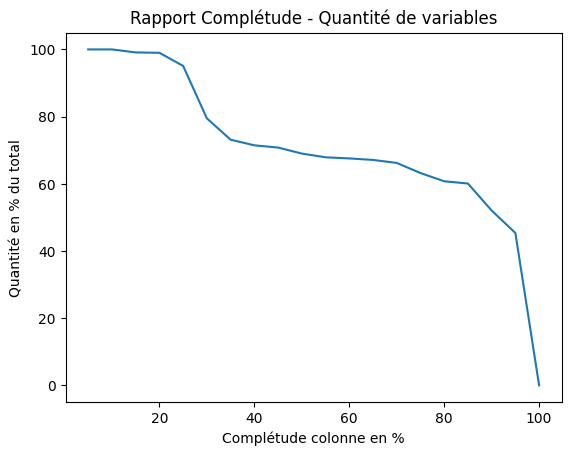

Pour une complétude de 5% : il reste 100.00% des individus
Pour une complétude de 10% : il reste 100.00% des individus
Pour une complétude de 15% : il reste 100.00% des individus
Pour une complétude de 20% : il reste 100.00% des individus
Pour une complétude de 25% : il reste 99.66% des individus
Pour une complétude de 30% : il reste 99.30% des individus
Pour une complétude de 35% : il reste 98.53% des individus
Pour une complétude de 40% : il reste 96.40% des individus
Pour une complétude de 45% : il reste 95.44% des individus
Pour une complétude de 50% : il reste 95.31% des individus
Pour une complétude de 55% : il reste 91.45% des individus
Pour une complétude de 60% : il reste 86.54% des individus
Pour une complétude de 65% : il reste 81.73% des individus
Pour une complétude de 70% : il reste 63.18% des individus
Pour une complétude de 75% : il reste 37.21% des individus
Pour une complétude de 80% : il reste 25.46% des individus
Pour une complétude de 85% : il reste 21.28% des indi

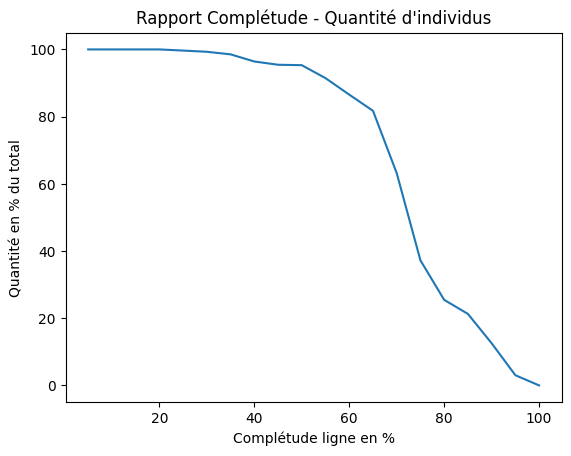

In [19]:
show_completeness(df_global)

Prenons des valeurs qui combinent quantité et complétude. Des points intéressants sont par exemple :

- Pour les colonnes : 70 et 85 de complétude permettent de garder 66 et 60 % de variables

- Pour les lignes : 50 et 65 permettent de garder 95 et 81 % des individus

NB : Ces chiffres seront à recalculer lorsqu'on aura effectuer un premier nettoyage des colonnes/des lignes.

In [9]:
# Calculate completeness for each column
completeness_value_col = df_global.notna().mean() * 100

# Identify columns with completeness greater than 85%
col_complete_85 = completeness_value_col > 85

# Keep only the columns with completeness greater than 85%
df_global_c85 = df_global.loc[:, col_complete_85]

In [23]:
df_global_c85.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356251 entries, 0 to 356254
Columns: 539 entries, index to completeness
dtypes: bool(133), float64(363), int64(43)
memory usage: 1.1 GB


Pour une complétude de 5% : il reste 100.00% des variables
Pour une complétude de 10% : il reste 100.00% des variables
Pour une complétude de 15% : il reste 100.00% des variables
Pour une complétude de 20% : il reste 100.00% des variables
Pour une complétude de 25% : il reste 100.00% des variables
Pour une complétude de 30% : il reste 100.00% des variables
Pour une complétude de 35% : il reste 100.00% des variables
Pour une complétude de 40% : il reste 100.00% des variables
Pour une complétude de 45% : il reste 100.00% des variables
Pour une complétude de 50% : il reste 100.00% des variables
Pour une complétude de 55% : il reste 100.00% des variables
Pour une complétude de 60% : il reste 100.00% des variables
Pour une complétude de 65% : il reste 100.00% des variables
Pour une complétude de 70% : il reste 100.00% des variables
Pour une complétude de 75% : il reste 100.00% des variables
Pour une complétude de 80% : il reste 100.00% des variables
Pour une complétude de 85% : il reste 100

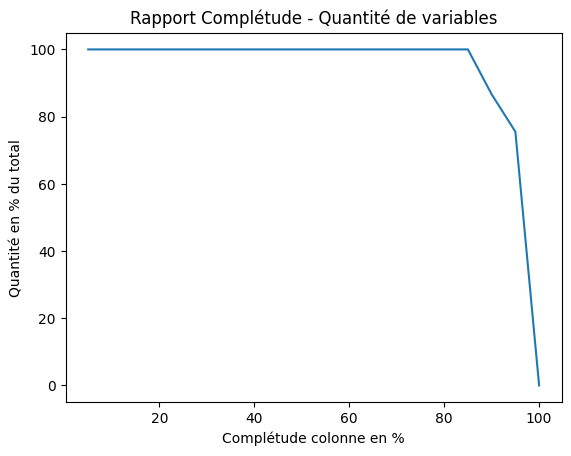

Pour une complétude de 5% : il reste 100.00% des individus
Pour une complétude de 10% : il reste 100.00% des individus
Pour une complétude de 15% : il reste 100.00% des individus
Pour une complétude de 20% : il reste 100.00% des individus
Pour une complétude de 25% : il reste 100.00% des individus
Pour une complétude de 30% : il reste 100.00% des individus
Pour une complétude de 35% : il reste 100.00% des individus
Pour une complétude de 40% : il reste 99.34% des individus
Pour une complétude de 45% : il reste 99.30% des individus
Pour une complétude de 50% : il reste 95.60% des individus
Pour une complétude de 55% : il reste 95.39% des individus
Pour une complétude de 60% : il reste 95.12% des individus
Pour une complétude de 65% : il reste 95.12% des individus
Pour une complétude de 70% : il reste 95.11% des individus
Pour une complétude de 75% : il reste 95.10% des individus
Pour une complétude de 80% : il reste 95.05% des individus
Pour une complétude de 85% : il reste 94.85% des i

C:\Users\gui\AppData\Local\Temp\ipykernel_10888\748716394.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["completeness"] = round(df.notna().mean(axis=1) * 100, 1)


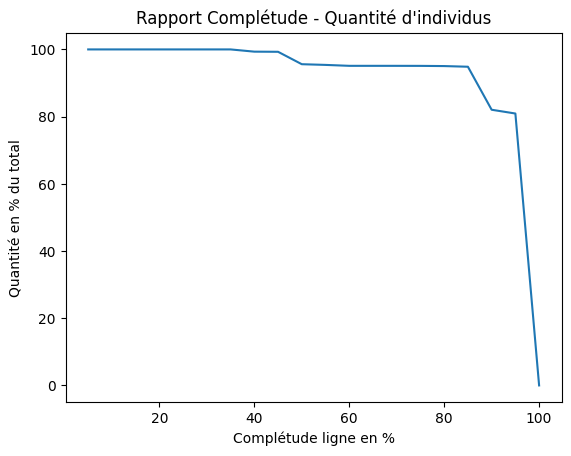

In [24]:
show_completeness(df_global_c85)

On garde une complétude de 85% pour les lignes dans df_global_c85.

In [10]:
# Calculate completeness for each column
completeness_value_row = df_global_c85.notna().mean(axis = 1) * 100

# Identify columns with completeness greater than 85%
row_complete_85 = completeness_value_row > 85

# Keep only the columns with completeness greater than 85%
df_global_c85_r85 = df_global_c85.loc[row_complete_85, :]

In [11]:
df_global_c85_r85.info()

<class 'pandas.core.frame.DataFrame'>
Index: 337890 entries, 0 to 356254
Columns: 538 entries, index to INSTAL_COUNT
dtypes: bool(133), float64(362), int64(43)
memory usage: 1.1 GB


## 2.2 NA

Imputation des NA pour les features sauf target :

In [12]:
# Calculate the median of each column excluding the "TARGET" column
medians = df_global_c85_r85.drop(columns=["TARGET"]).median()

# Replace inf with NA, Fill NA values with the median of each column, excluding the "TARGET" column
df_global_c85_r85_med = df_global_c85_r85.copy()
df_global_c85_r85_med = df_global_c85_r85_med.replace([np.inf, -np.inf], np.nan)
df_global_c85_r85_med[medians.index] = df_global_c85_r85[medians.index].fillna(medians)

Suppression des lignes sans valeur de target :

In [13]:
# Drop rows with missing values in the "TARGET" column
df_global_c85_r85_med = df_global_c85_r85_med.dropna(subset=["TARGET"])

df_global_c85_r85_med.shape

(290185, 538)

In [15]:
import numpy as np
import pandas as pd

# Assuming df_global_c85_r85_med is your DataFrame
# Replace infinite values with NaN
df_global_c85_r85_med = df_global_c85_r85_med.replace([np.inf, -np.inf], np.nan)

# Fill NaN values with the median of each column
df_global_c85_r85_med = df_global_c85_r85_med.fillna(df_global_c85_r85_med.median())

# Ensure all values are finite and not too large for float64
df_global_c85_r85_med = df_global_c85_r85_med.apply(lambda col: pd.to_numeric(col, errors='coerce').astype(np.float64) if col.dtype.kind in 'biufc' else col)

# Check for any remaining non-finite values
assert np.all(np.isfinite(df_global_c85_r85_med)), "There are still non-finite values in the data"

In [16]:
df_global_c85_r85_med.shape

(290185, 538)

Ce jeu de données nous servira de baseline.

## 2.3 Baselines

In [21]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

def sample_dataframe(df, target_col='TARGET', sample_size=10000, random_state=42):
    """
    Sample a DataFrame while maintaining the normalized distribution of the target column using StratifiedShuffleSplit.

    :param df: The DataFrame to sample.
    :param target_col: The column to maintain the distribution of.
    :param sample_size: The size of the sample to take.
    :param random_state: Random seed for reproducibility.
    :return: A sampled DataFrame.
    """
    # Calculate the fraction of the sample size relative to the full dataset
    sample_fraction = sample_size / len(df)

    # Initialize StratifiedShuffleSplit
    sss = StratifiedShuffleSplit(n_splits=1, test_size=sample_fraction, random_state=random_state)

    # Perform stratified sampling
    for train_index, test_index in sss.split(df, df[target_col]):
        df_sampled = df.iloc[test_index]

    return df_sampled

# Example usage
# Assuming df is your original DataFrame
df_global_c85_r85_med_sample = sample_dataframe(df_global_c85_r85_med, target_col='TARGET', sample_size=10000)

In [22]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Separate the features and target variable
X = df_global_c85_r85_med_sample.drop('TARGET', axis=1)
y = df_global_c85_r85_med_sample['TARGET']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Standard Scaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Train the classifier
rf_classifier.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test_scaled)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
roc = roc_auc_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"f1-score: {f1:.2f}")
print(f"ROC: {roc:.2f}")

2025/07/27 15:27:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ca0820514f2c4915898b9a1072ff4379', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/07/27 15:27:40 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
c:\Users\gui\.conda\envs\test\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


🏃 View run carefree-perch-517 at: http://127.0.0.1:5000/#/experiments/470186965741082687/runs/ca0820514f2c4915898b9a1072ff4379
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/470186965741082687
Accuracy: 0.92
Precision: 0.46
Recall: 0.50
f1-score: 0.48
ROC: 0.50


Pour MLflow :

In [ ]:
from pathlib import Path
import mlflow
from mlflow.exceptions import MlflowException
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score

# =================================================================
# STEP 1: SETUP AND ENABLE AUTOLOGGING
# =================================================================
mlflow.set_tracking_uri("http://127.0.0.1:5000")

experiment_name = "Removing Outliers"

try:
    experiment = mlflow.set_experiment(experiment_name)
    print(f"Experiment '{experiment_name}' set with ID: {experiment.experiment_id}")
except MlflowException as e:
    print(f"Error setting experiment: {e}")
    raise

# =================================================================
# STEP 2: DATA
# =================================================================
X = df_global_80_med_p1.drop('TARGET', axis=1)
y = df_global_80_med_p1['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check class distribution
print("Class distribution in y_train:", y_train.value_counts())
print("Class distribution in y_test:", y_test.value_counts())

# =================================================================
# STEP 3: ENABLE AUTOLOGGING
# =================================================================
mlflow.autolog(
    log_input_examples=True,
    log_model_signatures=True,
    log_models=True,
)

print("MLflow Autologging is enabled.")
print(f"Logging to experiment: '{experiment_name}'")

# =================================================================
# STEP 4: TRAIN MODELS
# =================================================================
print("\n--- Training Random Forest ---")
with mlflow.start_run(run_name="Baseline_RF_Target_Balanced"):
    model_rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, class_weight='balanced')
    model_rf.fit(X_train, y_train)

    # Manual evaluation
    y_pred = model_rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    print(f"Manual Accuracy Check: {accuracy:.4f}")
    print(f"Manual Precision Check: {precision:.4f}")

print("\n--- Training Random Forest ---")
with mlflow.start_run(run_name="Baseline_RF_Target_8"):
    model_rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    model_rf.fit(X_train, y_train)

    # Manual evaluation
    y_pred = model_rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    print(f"Manual Accuracy Check: {accuracy:.4f}")
    print(f"Manual Precision Check: {precision:.4f}")

2025/07/27 15:20:40 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 1.3.0 <= scikit-learn <= 1.7.0, but the installed version is 1.7.1. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


Experiment 'Baselines' set with ID: 470186965741082687
Class distribution in y_train: TARGET
0.0    7335
1.0     665
Name: count, dtype: int64
Class distribution in y_test: TARGET
0.0    1846
1.0     154
Name: count, dtype: int64


2025/07/27 15:20:40 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/07/27 15:20:40 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



MLflow Autologging is enabled.
Logging to experiment: 'Baselines'

--- Training Random Forest ---
Manual Accuracy Check: 0.7620
Manual Precision Check: 0.8830
🏃 View run Baseline_RF_Target_Balanced at: http://127.0.0.1:5000/#/experiments/470186965741082687/runs/1adf6b80b86b43d79344873566c28d09
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/470186965741082687

--- Training Random Forest ---


c:\Users\gui\.conda\envs\test\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Manual Accuracy Check: 0.9230
Manual Precision Check: 0.8519
🏃 View run Baseline_RF_Target_8 at: http://127.0.0.1:5000/#/experiments/470186965741082687/runs/3253851af531401792e13010d3450dc3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/470186965741082687


Pour le jeu déséquilibré, sans ajustement supplémentaires, le modèle prédit toujours 0. Cela explique accuracy élevée.

Quels sont les champs d'actions possibles pour améliorer la baseline ?

<b> <u> DATA </b> </u> 

Preprocessing
- dataframe de départ 
- valeur de complétude colonnes et lignes souhaitée pour le nettoyage
- valeur d'imputation des valeurs manquantes

Feature Engineering
- nombre de features selectionnée (sélection + création)
- valeurs de corrélation acceptée entre features

Réduction de dimensions 
- définir le nombre de dimensions souhaitée (ou la variance)

Gestion du déséquilibre target
- oversample une sous-représentation initiale
- sample pour une valeur du déséquilibre fixée


<b> <u> MODELE </b> </u>

Algorithme de départ : choisir parmi d'autres classifications method

Valeur de la probabilité : ajouter une métrique d'entrainement

Valeur du predict : Ajustement du treshold

Hyperparamètres : optimiser

## 2.4 Experiments

### Simple

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def preprocess(df, target_col, completeness=80, impute='median', unique_val_threshold=1, verbose=True):
    """
    Preprocesses a DataFrame by handling missing values, dropping irrelevant columns,
    and visualizing data completeness.

    Args:
        df (pd.DataFrame): The input DataFrame.
        target_col (str): The name of the target column.
        completeness (int, optional): The minimum percentage of non-missing values a column
                                      or row must have to be retained. Defaults to 80.
        impute (str, optional): The imputation method for missing values ('median', 'mean', 'mode').
                                Defaults to 'median'.
        unique_val_threshold (int, optional): Columns with unique values less than or equal to this
                                              threshold will be dropped. Defaults to 1.
        verbose (bool, optional): If True, print detailed information and show plots. Defaults to True.

    Returns:
        pd.DataFrame: The preprocessed DataFrame.
    """

    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input 'df' must be a pandas DataFrame.")
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in the DataFrame.")
    if not (0 <= completeness <= 100):
        raise ValueError("Completeness threshold must be between 0 and 100.")
    if impute not in ['median', 'mean', 'mode']:
        raise ValueError("Impute method must be 'median', 'mean', or 'mode'.")

    df_processed = df.copy()

    if verbose:
        print("--- Initial DataFrame Info ---")
        print(f"Shape: {df_processed.shape}")
        print("Data Types:\n", df_processed.dtypes)
        print("\nMissing values before preprocessing:")
        print(df_processed.isnull().sum()[df_processed.isnull().sum() > 0].sort_values(ascending=False))

    # 1. Visualize NA per columns on a bargraph
    if verbose:
        plt.figure(figsize=(12, 6))
        missing_values_col = df_processed.isnull().sum()
        missing_values_col = missing_values_col[missing_values_col > 0].sort_values(ascending=False)
        if not missing_values_col.empty:
            sns.barplot(x=missing_values_col.index, y=missing_values_col.values)
            plt.xticks(rotation=90)
            plt.title('Number of Missing Values Per Column (Before Preprocessing)')
            plt.ylabel('Number of Missing Values')
            plt.xlabel('Columns')
            plt.tight_layout()
            plt.show()
        else:
            print("\nNo missing values in columns to visualize before preprocessing.")

    # 2. Visualize number of rows/col corresponding to completeness values
    if verbose:
        # Column completeness
        col_completeness = (1 - df_processed.isnull().sum() / len(df_processed)) * 100
        plt.figure(figsize=(12, 6))
        sns.histplot(col_completeness, bins=20, kde=True)
        plt.title('Distribution of Column Completeness (%)')
        plt.xlabel('Completeness (%)')
        plt.ylabel('Number of Columns')
        plt.tight_layout()
        plt.show()

        # Row completeness
        row_completeness = (1 - df_processed.isnull().sum(axis=1) / df_processed.shape[1]) * 100
        plt.figure(figsize=(12, 6))
        sns.histplot(row_completeness, bins=20, kde=True)
        plt.title('Distribution of Row Completeness (%)')
        plt.xlabel('Completeness (%)')
        plt.ylabel('Number of Rows')
        plt.tight_layout()
        plt.show()

    # 3. Drop rows with missing target value
    initial_rows = df_processed.shape[0]
    if df_processed[target_col].isnull().any():
        df_processed.dropna(subset=[target_col], inplace=True)
        if verbose:
            print(f"\nDropped {initial_rows - df_processed.shape[0]} rows due to missing target value in '{target_col}'.")
    elif verbose:
        print(f"\nNo missing values found in the target column '{target_col}'.")

    # 4. Drop unusefull columns: unique values ≤ unique_val_threshold
    cols_to_drop_unique = []
    for col in df_processed.columns:
        if col == target_col: # Do not drop target column based on unique values
            continue
        if df_processed[col].nunique() <= unique_val_threshold:
            cols_to_drop_unique.append(col)
    if cols_to_drop_unique:
        df_processed.drop(columns=cols_to_drop_unique, inplace=True)
        if verbose:
            print(f"Dropped columns with {unique_val_threshold} or fewer unique values: {cols_to_drop_unique}")
    elif verbose:
        print(f"No columns dropped based on unique value threshold (<= {unique_val_threshold}).")


    # 5. Drop columns with completeness less than input
    initial_cols = df_processed.shape[1]
    col_completeness = (1 - df_processed.isnull().sum() / len(df_processed)) * 100
    cols_to_drop_completeness = col_completeness[col_completeness < completeness].index.tolist()
    if cols_to_drop_completeness:
        df_processed.drop(columns=cols_to_drop_completeness, inplace=True)
        if verbose:
            print(f"Dropped {initial_cols - df_processed.shape[1]} columns due to completeness < {completeness}%: {cols_to_drop_completeness}")
    elif verbose:
        print(f"No columns dropped due to completeness less than {completeness}%.")

    # 6. Drop rows with completeness less than input
    initial_rows_after_col_drop = df_processed.shape[0]
    row_completeness = (1 - df_processed.isnull().sum(axis=1) / df_processed.shape[1]) * 100
    rows_to_drop_completeness = df_processed[row_completeness < completeness].index
    if not rows_to_drop_completeness.empty:
        df_processed.drop(index=rows_to_drop_completeness, inplace=True)
        if verbose:
            print(f"Dropped {initial_rows_after_col_drop - df_processed.shape[0]} rows due to completeness < {completeness}%.")
    elif verbose:
        print(f"No rows dropped due to completeness less than {completeness}%.")

    # 7. Fill NA with median or mean or mode (input)
    if verbose:
        print(f"\n--- Imputing missing values using '{impute}' method ---")
        print("Missing values before imputation:")
        print(df_processed.isnull().sum()[df_processed.isnull().sum() > 0])

    numerical_cols = df_processed.select_dtypes(include=np.number).columns
    categorical_cols = df_processed.select_dtypes(include='object').columns

    for col in df_processed.columns:
        if df_processed[col].isnull().any():
            if col in numerical_cols:
                if impute == 'median':
                    fill_value = df_processed[col].median()
                elif impute == 'mean':
                    fill_value = df_processed[col].mean()
                elif impute == 'mode':
                    # Mode can return multiple values, take the first one
                    fill_value = df_processed[col].mode()[0]
                df_processed[col].fillna(fill_value, inplace=True)
                if verbose:
                    print(f"  Filled NA in numerical column '{col}' with {impute} ({fill_value}).")
            elif col in categorical_cols:
                # Always use mode for categorical columns
                fill_value = df_processed[col].mode()[0]
                df_processed[col].fillna(fill_value, inplace=True)
                if verbose:
                    print(f"  Filled NA in categorical column '{col}' with mode ({fill_value}).")
            else:
                if verbose:
                    print(f"  Skipping imputation for column '{col}' as its type is not numerical or categorical.")

    # 8. Verify number, type of columns before and after imputation
    if verbose:
        print("\n--- DataFrame Info After Preprocessing and Imputation ---")
        print(f"Final Shape: {df_processed.shape}")
        print("Final Data Types:\n", df_processed.dtypes)
        if df_processed.isnull().sum().sum() == 0:
            print("\nAll missing values have been handled.")
        else:
            print("\nRemaining missing values (should be 0 if all handled):")
            print(df_processed.isnull().sum()[df_processed.isnull().sum() > 0])

    return df_processed

--- Initial DataFrame Info ---
Shape: (356251, 896)
Data Types:
 index                                   int64
SK_ID_CURR                              int64
TARGET                                float64
CODE_GENDER                             int64
FLAG_OWN_CAR                            int64
                                       ...   
CC_NAME_CONTRACT_STATUS_nan_MEAN      float64
CC_NAME_CONTRACT_STATUS_nan_SUM       float64
CC_NAME_CONTRACT_STATUS_nan_VAR       float64
CC_NAME_CONTRACT_STATUS_nan_MEDIAN    float64
CC_COUNT                              float64
Length: 896, dtype: object

Missing values before preprocessing:
REFUSED_RATE_DOWN_PAYMENT_MAX       303648
REFUSED_RATE_DOWN_PAYMENT_MEAN      303648
REFUSED_RATE_DOWN_PAYMENT_MEDIAN    303648
REFUSED_AMT_DOWN_PAYMENT_MEAN       303648
REFUSED_AMT_DOWN_PAYMENT_MEDIAN     303648
                                     ...  
PAYMENT_RATE                            36
AMT_ANNUITY                             36
INCOME_PER_PERSON   

C:\Users\gui\AppData\Local\Temp\ipykernel_14304\3068761187.py:55: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


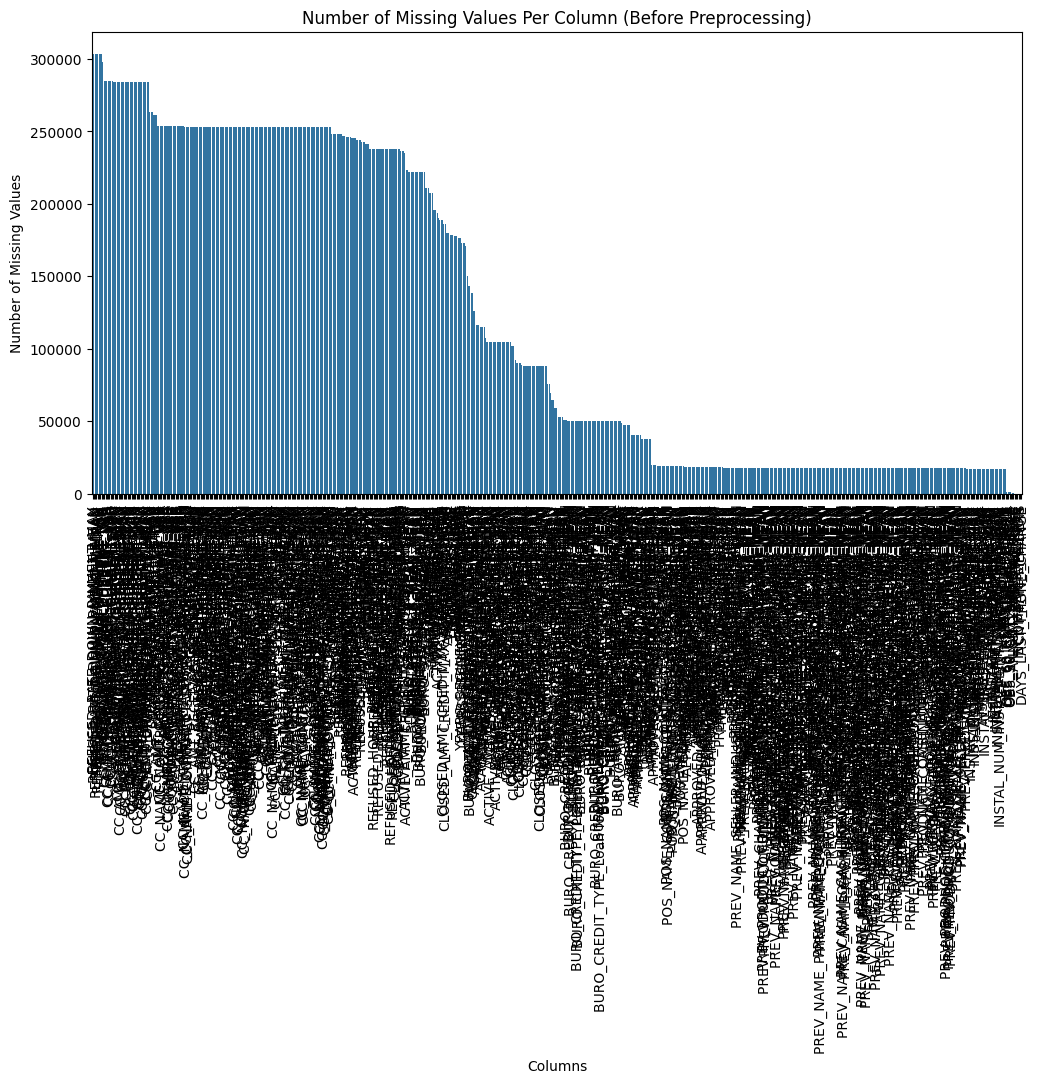

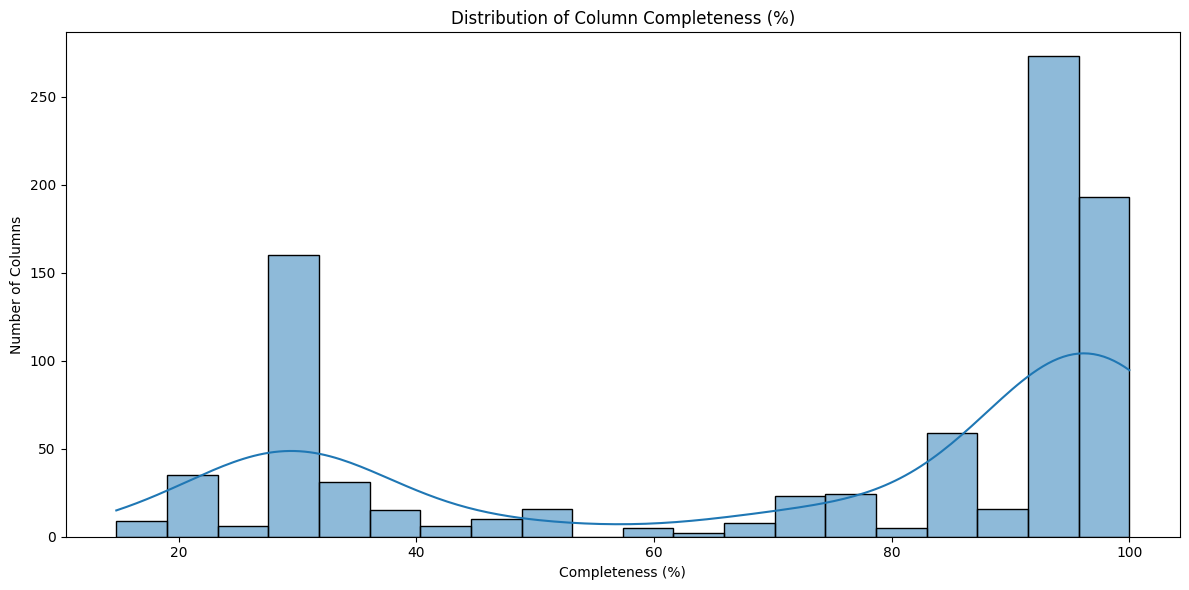

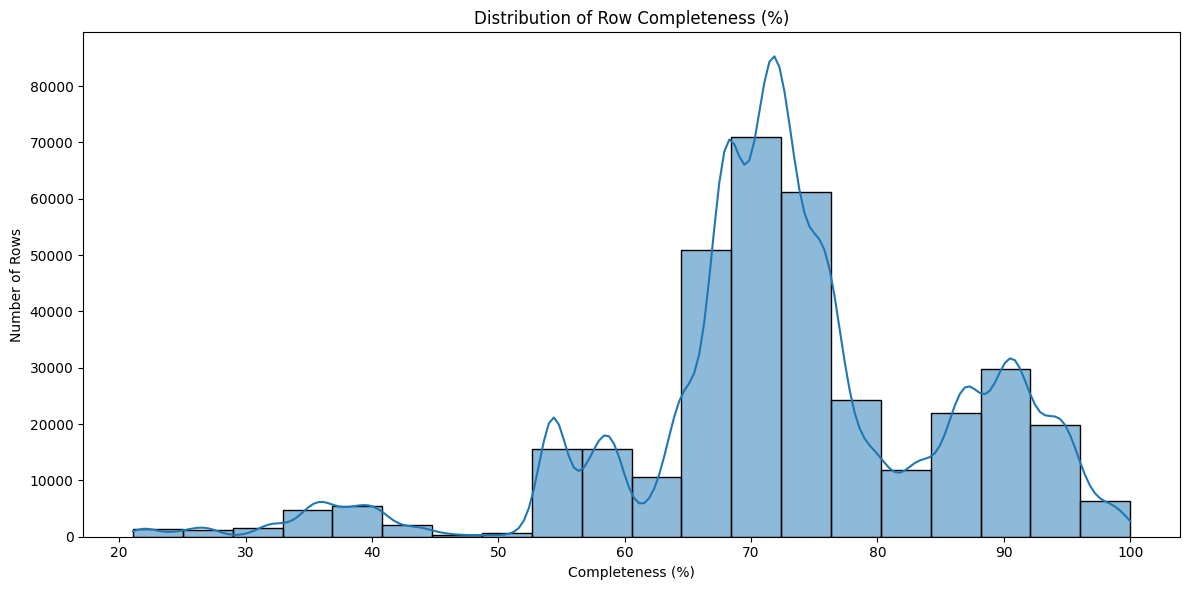


Dropped 48744 rows due to missing target value in 'TARGET'.
Dropped columns with 1 or fewer unique values: ['BURO_CREDIT_ACTIVE_nan_MEAN', 'BURO_CREDIT_CURRENCY_nan_MEAN', 'BURO_CREDIT_TYPE_nan_MEAN', 'BURO_STATUS_nan_MEAN_MEAN', 'PREV_NAME_CONTRACT_TYPE_nan_MEAN', 'PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN', 'PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN', 'PREV_NAME_CONTRACT_STATUS_nan_MEAN', 'PREV_NAME_PAYMENT_TYPE_nan_MEAN', 'PREV_CODE_REJECT_REASON_nan_MEAN', 'PREV_NAME_CLIENT_TYPE_nan_MEAN', 'PREV_NAME_GOODS_CATEGORY_House Construction_MEAN', 'PREV_NAME_GOODS_CATEGORY_nan_MEAN', 'PREV_NAME_PORTFOLIO_nan_MEAN', 'PREV_NAME_PRODUCT_TYPE_nan_MEAN', 'PREV_CHANNEL_TYPE_nan_MEAN', 'PREV_NAME_SELLER_INDUSTRY_nan_MEAN', 'PREV_NAME_YIELD_GROUP_nan_MEAN', 'POS_NAME_CONTRACT_STATUS_nan_MEAN', 'CC_SK_DPD_MIN', 'CC_SK_DPD_DEF_MIN', 'CC_NAME_CONTRACT_STATUS_Approved_MIN', 'CC_NAME_CONTRACT_STATUS_Approved_MEDIAN', 'CC_NAME_CONTRACT_STATUS_Demand_MIN', 'CC_NAM

C:\Users\gui\AppData\Local\Temp\ipykernel_14304\3068761187.py:147: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed[col].fillna(fill_value, inplace=True)
C:\Users\gui\AppData\Local\Temp\ipykernel_14304\3068761187.py:147: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

  Filled NA in numerical column 'AMT_ANNUITY' with median (24939.0).
  Filled NA in numerical column 'AMT_GOODS_PRICE' with median (450000.0).
  Filled NA in numerical column 'DAYS_EMPLOYED' with median (-1664.0).
  Filled NA in numerical column 'EXT_SOURCE_2' with median (0.5643975951807224).
  Filled NA in numerical column 'EXT_SOURCE_3' with median (0.5352762504724826).
  Filled NA in numerical column 'OBS_30_CNT_SOCIAL_CIRCLE' with median (0.0).
  Filled NA in numerical column 'DEF_30_CNT_SOCIAL_CIRCLE' with median (0.0).
  Filled NA in numerical column 'OBS_60_CNT_SOCIAL_CIRCLE' with median (0.0).
  Filled NA in numerical column 'DEF_60_CNT_SOCIAL_CIRCLE' with median (0.0).
  Filled NA in numerical column 'AMT_REQ_CREDIT_BUREAU_HOUR' with median (0.0).
  Filled NA in numerical column 'AMT_REQ_CREDIT_BUREAU_DAY' with median (0.0).
  Filled NA in numerical column 'AMT_REQ_CREDIT_BUREAU_WEEK' with median (0.0).
  Filled NA in numerical column 'AMT_REQ_CREDIT_BUREAU_MON' with median (

C:\Users\gui\AppData\Local\Temp\ipykernel_14304\3068761187.py:147: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed[col].fillna(fill_value, inplace=True)
C:\Users\gui\AppData\Local\Temp\ipykernel_14304\3068761187.py:147: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

  Filled NA in numerical column 'BURO_AMT_CREDIT_SUM_MAX' with median (450000.0).
  Filled NA in numerical column 'BURO_AMT_CREDIT_SUM_MEAN' with median (192394.125).
  Filled NA in numerical column 'BURO_AMT_CREDIT_SUM_SUM' with median (957667.9725).
  Filled NA in numerical column 'BURO_AMT_CREDIT_SUM_MEDIAN' with median (130505.08499999999).
  Filled NA in numerical column 'BURO_AMT_CREDIT_SUM_DEBT_MAX' with median (151083.0).
  Filled NA in numerical column 'BURO_AMT_CREDIT_SUM_DEBT_MEAN' with median (44467.5).
  Filled NA in numerical column 'BURO_AMT_CREDIT_SUM_DEBT_SUM' with median (171913.5).
  Filled NA in numerical column 'BURO_AMT_CREDIT_SUM_DEBT_MEDIAN' with median (0.0).
  Filled NA in numerical column 'BURO_AMT_CREDIT_SUM_OVERDUE_MEAN' with median (0.0).
  Filled NA in numerical column 'BURO_AMT_CREDIT_SUM_OVERDUE_MEDIAN' with median (0.0).
  Filled NA in numerical column 'BURO_AMT_CREDIT_SUM_LIMIT_SUM' with median (0.0).
  Filled NA in numerical column 'BURO_CNT_CREDIT_P

C:\Users\gui\AppData\Local\Temp\ipykernel_14304\3068761187.py:147: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed[col].fillna(fill_value, inplace=True)
C:\Users\gui\AppData\Local\Temp\ipykernel_14304\3068761187.py:147: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

  Filled NA in numerical column 'PREV_AMT_ANNUITY_MIN' with median (5721.435).
  Filled NA in numerical column 'PREV_AMT_ANNUITY_MAX' with median (17910.855).
  Filled NA in numerical column 'PREV_AMT_ANNUITY_MEAN' with median (11984.214375).
  Filled NA in numerical column 'PREV_AMT_ANNUITY_MEDIAN' with median (10755.630000000001).
  Filled NA in numerical column 'PREV_APP_CREDIT_PERC_MIN' with median (0.8988017169428878).
  Filled NA in numerical column 'PREV_APP_CREDIT_PERC_MAX' with median (1.042644533485976).
  Filled NA in numerical column 'PREV_APP_CREDIT_PERC_MEAN' with median (0.9714917127071823).
  Filled NA in numerical column 'PREV_APP_CREDIT_PERC_MEDIAN' with median (0.9928007199280072).
  Filled NA in numerical column 'PREV_AMT_DOWN_PAYMENT_MIN' with median (0.0).
  Filled NA in numerical column 'PREV_AMT_DOWN_PAYMENT_MAX' with median (5850.0).
  Filled NA in numerical column 'PREV_AMT_DOWN_PAYMENT_MEAN' with median (3375.0).
  Filled NA in numerical column 'PREV_AMT_DOWN

C:\Users\gui\AppData\Local\Temp\ipykernel_14304\3068761187.py:147: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed[col].fillna(fill_value, inplace=True)
C:\Users\gui\AppData\Local\Temp\ipykernel_14304\3068761187.py:147: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

  Filled NA in numerical column 'POS_MONTHS_BALANCE_MEAN' with median (-28.5).
  Filled NA in numerical column 'POS_MONTHS_BALANCE_SIZE' with median (22.0).
  Filled NA in numerical column 'POS_MONTHS_BALANCE_MEDIAN' with median (-24.0).
  Filled NA in numerical column 'POS_SK_DPD_MAX' with median (0.0).
  Filled NA in numerical column 'POS_SK_DPD_MEAN' with median (0.0).
  Filled NA in numerical column 'POS_SK_DPD_MEDIAN' with median (0.0).
  Filled NA in numerical column 'POS_SK_DPD_DEF_MAX' with median (0.0).
  Filled NA in numerical column 'POS_SK_DPD_DEF_MEAN' with median (0.0).
  Filled NA in numerical column 'POS_SK_DPD_DEF_MEDIAN' with median (0.0).
  Filled NA in numerical column 'POS_NAME_CONTRACT_STATUS_Active_MEAN' with median (0.9166666666666666).
  Filled NA in numerical column 'POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN' with median (0.0).
  Filled NA in numerical column 'POS_NAME_CONTRACT_STATUS_Approved_MEAN' with median (0.0).
  Filled NA in numerical column 'POS_NA

C:\Users\gui\AppData\Local\Temp\ipykernel_14304\3068761187.py:147: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed[col].fillna(fill_value, inplace=True)
C:\Users\gui\AppData\Local\Temp\ipykernel_14304\3068761187.py:147: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

  Filled NA in numerical column 'INSTAL_AMT_INSTALMENT_MAX' with median (35571.51).
  Filled NA in numerical column 'INSTAL_AMT_INSTALMENT_MEAN' with median (12623.3409375).
  Filled NA in numerical column 'INSTAL_AMT_INSTALMENT_SUM' with median (330202.89).
  Filled NA in numerical column 'INSTAL_AMT_INSTALMENT_MEDIAN' with median (9392.49).
  Filled NA in numerical column 'INSTAL_AMT_PAYMENT_MIN' with median (2323.26).
  Filled NA in numerical column 'INSTAL_AMT_PAYMENT_MAX' with median (36127.259999999995).
  Filled NA in numerical column 'INSTAL_AMT_PAYMENT_MEAN' with median (12282.309485294118).
  Filled NA in numerical column 'INSTAL_AMT_PAYMENT_SUM' with median (320331.915).
  Filled NA in numerical column 'INSTAL_AMT_PAYMENT_MEDIAN' with median (9040.5).
  Filled NA in numerical column 'INSTAL_DAYS_ENTRY_PAYMENT_MAX' with median (-65.0).
  Filled NA in numerical column 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN' with median (-803.0993713733076).
  Filled NA in numerical column 'INSTAL_DAY

C:\Users\gui\AppData\Local\Temp\ipykernel_14304\3068761187.py:147: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed[col].fillna(fill_value, inplace=True)
C:\Users\gui\AppData\Local\Temp\ipykernel_14304\3068761187.py:147: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e


All missing values have been handled.


In [ ]:
df_global_80_med = preprocess(df = df_global, target_col = "TARGET", completeness=80, impute='median', unique_val_threshold=1, verbose=True)

In [8]:
# --- Save to Parquet ---
df_global_80_med.to_parquet('df_global_80_med.parquet', engine='pyarrow')

### Multiple

### Mlflow

# X - Outlier et scaling

In [5]:
import pandas as pd
import numpy as np

def remove_percent_outliers_2sides(df, percent):
    # Create a copy of the original DataFrame
    df_cleaned = df.copy()

    # Convert each column to numeric, forcing errors to NaN
    for feat in df_cleaned.columns:
        df_cleaned[feat] = pd.to_numeric(df_cleaned[feat], errors='coerce')

    # Drop rows with NaN values that resulted from coercion
    df_cleaned = df_cleaned.dropna()

    # Ensure that the DataFrame is not empty after dropping NaN values
    if df_cleaned.empty:
        print("DataFrame is empty after dropping NaN values.")
        return df_cleaned

    # Collect outlier indices
    all_outlier_indices = []
    lower_quantile = percent / 100
    upper_quantile = (100 - percent) / 100

    for feat in df_cleaned.select_dtypes(include=[np.number]).columns:
        # Calculate the thresholds for outlier detection
        lower_val = df_cleaned[feat].quantile(lower_quantile)
        upper_val = df_cleaned[feat].quantile(upper_quantile)

        # Identify outliers on both sides
        outlier_rows = df_cleaned[(df_cleaned[feat] < lower_val) | (df_cleaned[feat] > upper_val)]

        # Collect outlier indices
        outlier_indices = outlier_rows.index.tolist()
        all_outlier_indices.extend(outlier_indices)

    # Remove duplicate indices
    all_outlier_indices = list(set(all_outlier_indices))
    print(f"Number of total outliers = {len(all_outlier_indices)}")

    # Remove outliers from the DataFrame
    df_cleaned = df_cleaned.drop(index=all_outlier_indices)

    return df_cleaned

In [6]:
df_global_80_med_p1 = remove_percent_outliers_2sides(df = df_global_80_med, percent = 1)

Number of total outliers = 215729


In [7]:
df_global_80_med_p1.shape

(75096, 525)

In [31]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler


def evaluate_rfc(df):

    # Separate the features and target variable
    X = df.drop('TARGET', axis=1)
    y = df['TARGET']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the Standard Scaler
    scaler = StandardScaler()

    # Fit and transform the training data
    X_train_scaled = scaler.fit_transform(X_train)

    # Transform the test data
    X_test_scaled = scaler.transform(X_test)

    # Initialize the Random Forest Classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

    # Train the classifier
    rf_classifier.fit(X_train_scaled, y_train)

    # Make predictions on the test set
    y_pred = rf_classifier.predict(X_test_scaled)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    roc_macro = roc_auc_score(y_test, y_pred, average='macro')

    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    roc = roc_auc_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.2f}")

    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"f1-score: {f1:.2f}")
    print(f"ROC: {roc:.2f}")

    print(f"Precision macro : {precision_macro:.2f}")
    print(f"Recall macro : {recall_macro:.2f}")
    print(f"f1-score macro : {f1_macro:.2f}")
    print(f"ROC macro : {roc_macro:.2f}")

In [32]:
evaluate_rfc(df_global_80_med_p1)

Accuracy: 0.93
Precision: 0.86
Recall: 0.93
f1-score: 0.90
ROC: 0.50
Precision macro : 0.46
Recall macro : 0.50
f1-score macro : 0.48
ROC macro : 0.50


In [ ]:
from pathlib import Path
import mlflow
from mlflow.exceptions import MlflowException
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score

# =================================================================
# STEP 1: SETUP AND ENABLE AUTOLOGGING
# =================================================================
mlflow.set_tracking_uri("http://127.0.0.1:5000")

experiment_name = "Removing Outliers"

try:
    experiment = mlflow.set_experiment(experiment_name)
    print(f"Experiment '{experiment_name}' set with ID: {experiment.experiment_id}")
except MlflowException as e:
    print(f"Error setting experiment: {e}")
    raise

# =================================================================
# STEP 2: DATA
# =================================================================
X = df_global_80_med_p1.drop('TARGET', axis=1)
y = df_global_80_med_p1['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check class distribution
print("Class distribution in y_train:", y_train.value_counts())
print("Class distribution in y_test:", y_test.value_counts())

# =================================================================
# STEP 3: ENABLE AUTOLOGGING
# =================================================================
mlflow.autolog(
    log_input_examples=True,
    log_model_signatures=True,
    log_models=True,
)

print("MLflow Autologging is enabled.")
print(f"Logging to experiment: '{experiment_name}'")

# =================================================================
# STEP 4: TRAIN MODELS
# =================================================================
print("\n--- Training Random Forest ---")
with mlflow.start_run(run_name="Baseline_RF_Target_Balanced"):
    model_rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, class_weight='balanced')
    model_rf.fit(X_train, y_train)

    # Manual evaluation
    y_pred = model_rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    print(f"Manual Accuracy Check: {accuracy:.4f}")
    print(f"Manual Precision Check: {precision:.4f}")

    # Log metrics manually
    mlflow.log_metric("test_accuracy", accuracy)
    mlflow.log_metric("test_precision", precision)

print("\n--- Training Random Forest ---")
with mlflow.start_run(run_name="Baseline_RF_Target_8"):
    model_rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    model_rf.fit(X_train, y_train)

    # Manual evaluation
    y_pred = model_rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    print(f"Manual Accuracy Check: {accuracy:.4f}")
    print(f"Manual Precision Check: {precision:.4f}")

    # Log metrics manually
    mlflow.log_metric("test_accuracy", accuracy)
    mlflow.log_metric("test_precision", precision)

2025/07/30 10:08:32 INFO mlflow.tracking.fluent: Experiment with name 'Removing Outliers' does not exist. Creating a new experiment.


Experiment 'Removing Outliers' set with ID: 525104640452152357


2025/07/30 10:08:33 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 1.3.0 <= scikit-learn <= 1.7.0, but the installed version is 1.7.1. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


Class distribution in y_train: TARGET
0.0    55622
1.0     4454
Name: count, dtype: int64
Class distribution in y_test: TARGET
0.0    13956
1.0     1064
Name: count, dtype: int64


2025/07/30 10:08:33 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/07/30 10:08:33 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



MLflow Autologging is enabled.
Logging to experiment: 'Removing Outliers'

--- Training Random Forest ---


2025/07/30 10:08:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\gui\.conda\envs\test\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/07/30 10:09:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\gui\.conda\envs\test\Lib\site-packages\ml

Manual Accuracy Check: 0.6809
Manual Precision Check: 0.8987
🏃 View run Baseline_RF_Target_Balanced at: http://127.0.0.1:5000/#/experiments/525104640452152357/runs/373fb14041534cc48a052c6acc41ceb6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/525104640452152357

--- Training Random Forest ---


2025/07/30 10:09:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\gui\.conda\envs\test\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/07/30 10:10:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\gui\.conda\envs\test\Lib\site-packages\ml

Manual Accuracy Check: 0.9292
Manual Precision Check: 0.8633
🏃 View run Baseline_RF_Target_8 at: http://127.0.0.1:5000/#/experiments/525104640452152357/runs/85cecdee91774d4789b21227b6836a51
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/525104640452152357


# M - Model Evaluation

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Define the custom score function
def custom_confusion_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape == (2, 2):  # Binary classification
        tn, fp, fn, tp = cm.ravel()
        score = tp - fp - 8 * fn + 4 * tn
    else:
        score = "N/A (Multi-class requires specific class selection)"
        print("Warning: Custom score is designed for binary classification")
    return score

def evaluate_rfc(df):
    try:
        # Check if input is a valid DataFrame
        if not isinstance(df, pd.DataFrame):
            raise ValueError("Input 'df' must be a pandas DataFrame")
        if df.empty:
            raise ValueError("Input DataFrame is empty")
        if 'TARGET' not in df.columns:
            raise ValueError("DataFrame must contain a 'TARGET' column")

        # Convert boolean columns to numeric (0/1) for features (excluding TARGET)
        df = df.copy()  # Avoid modifying the original DataFrame
        for col in df.columns:
            if col != 'TARGET' and df[col].dtype == bool:
                df[col] = df[col].astype(int)

        # Verify that features are numeric
        X = df.drop('TARGET', axis=1)
        if not all(X.dtypes.apply(lambda x: np.issubdtype(x, np.number))):
            raise ValueError("All features must be numeric")

        # Separate the features and target variable
        y = df['TARGET']

        # Check for valid target values (binary classification: 0 and 1)
        if not set(y.unique()).issubset({0, 1}):
            raise ValueError("Target column must contain binary values (0 and 1)")

        # Split the data into training+validation (80%) and test (20%) sets
        X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
        # Further split training+validation into training (60%) and validation (20%) sets
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

        # Initialize the Standard Scaler
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)

        # Initialize and train the Random Forest Classifier
        rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
        rf_classifier.fit(X_train_scaled, y_train)

        # Get predicted probabilities for validation and test sets
        y_val_prob = rf_classifier.predict_proba(X_val_scaled)[:, 1]  # Probability for class 1
        y_test_prob = rf_classifier.predict_proba(X_test_scaled)[:, 1]

        # Find optimal threshold on validation set
        thresholds = np.arange(0.1, 1.0, 0.05)
        best_threshold = 0.5
        best_val_custom_score = float('-inf')

        for threshold in thresholds:
            y_val_pred = (y_val_prob >= threshold).astype(int)
            val_custom_score = custom_confusion_score(y_val, y_val_pred)
            if isinstance(val_custom_score, str):  # Handle multi-class case
                raise ValueError("Custom score computation failed: multi-class detected")
            if val_custom_score > best_val_custom_score:
                best_val_custom_score = val_custom_score
                best_threshold = threshold

        print(f"Optimal threshold (maximizing custom score): {best_threshold:.2f}")
        print(f"Best validation custom score: {best_val_custom_score:.2f}")

        # Make predictions using the optimal threshold
        y_val_pred = (y_val_prob >= best_threshold).astype(int)
        y_test_pred = (y_test_prob >= best_threshold).astype(int)

        # Calculate custom score for validation and test sets
        val_custom_score = custom_confusion_score(y_val, y_val_pred)
        test_custom_score = custom_confusion_score(y_test, y_test_pred)

        # Calculate standard metrics for validation set
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_precision = precision_score(y_val, y_val_pred, average='weighted', zero_division=0)
        val_recall = recall_score(y_val, y_val_pred, average='weighted', zero_division=0)
        val_f1 = f1_score(y_val, y_val_pred, average='weighted', zero_division=0)
        val_roc = roc_auc_score(y_val, y_val_prob)  # Use probabilities for ROC
        val_precision_macro = precision_score(y_val, y_val_pred, average='macro', zero_division=0)
        val_recall_macro = recall_score(y_val, y_val_pred, average='macro', zero_division=0)
        val_f1_macro = f1_score(y_val, y_val_pred, average='macro', zero_division=0)
        val_roc_macro = roc_auc_score(y_val, y_val_prob, multi_class='ovr')

        # Calculate standard metrics for test set
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
        test_recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
        test_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
        test_roc = roc_auc_score(y_test, y_test_prob)  # Use probabilities for ROC
        test_precision_macro = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
        test_recall_macro = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
        test_f1_macro = f1_score(y_test, y_test_pred, average='macro', zero_division=0)
        test_roc_macro = roc_auc_score(y_test, y_test_prob, multi_class='ovr')

        # Print validation metrics
        print("\nValidation Metrics (using optimal threshold):")
        print(f"Custom Score (TP - FP - 8*FN + 4*TN): {val_custom_score}")
        print(f"Accuracy: {val_accuracy:.2f}")
        print(f"Precision: {val_precision:.2f}")
        print(f"Recall: {val_recall:.2f}")
        print(f"F1-score: {val_f1:.2f}")
        print(f"ROC: {val_roc:.2f}")
        print(f"Precision macro: {val_precision_macro:.2f}")
        print(f"Recall macro: {val_recall_macro:.2f}")
        print(f"F1-score macro: {val_f1_macro:.2f}")
        print(f"ROC macro: {val_roc_macro:.2f}")

        # Print test metrics
        print("\nTest Metrics (using optimal threshold):")
        print(f"Custom Score (TP - FP - 8*FN + 4*TN): {test_custom_score}")
        print(f"Accuracy: {test_accuracy:.2f}")
        print(f"Precision: {test_precision:.2f}")
        print(f"Recall: {test_recall:.2f}")
        print(f"F1-score: {test_f1:.2f}")
        print(f"ROC: {test_roc:.2f}")
        print(f"Precision macro: {test_precision_macro:.2f}")
        print(f"Recall macro: {test_recall_macro:.2f}")
        print(f"F1-score macro: {test_f1_macro:.2f}")
        print(f"ROC macro: {test_roc_macro:.2f}")

        return rf_classifier, val_custom_score, test_custom_score

    except Exception as e:
        print(f"Error in evaluate_rfc: {str(e)}")
        return None, None, None

In [14]:
model, val_custom_score, test_custom_score = evaluate_rfc(df =df_global_80_med_p1)

Optimal threshold (maximizing custom score): 0.20
Best validation custom score: 46849.00

Validation Metrics (using optimal threshold):
Custom Score (TP - FP - 6*FN + 3*TN): 46849
Accuracy: 0.93
Precision: 0.93
Recall: 0.93
F1-score: 0.89
ROC: 0.71
Precision macro: 0.96
Recall macro: 0.50
F1-score macro: 0.48
ROC macro: 0.71

Test Metrics (using optimal threshold):
Custom Score (TP - FP - 6*FN + 3*TN): 46841
Accuracy: 0.93
Precision: 0.93
Recall: 0.93
F1-score: 0.89
ROC: 0.72
Precision macro: 0.96
Recall macro: 0.50
F1-score macro: 0.48
ROC macro: 0.72


In [20]:
model

,n_estimators,100
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [21]:
df_global_80_med_p1.sample(2)

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_AMT_PAYMENT_MEDIAN,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MEDIAN,INSTAL_COUNT
96213,96213,211699,0.0,0,1,0,0,337500.0,269550.0,21294.0,...,3237.30,29003.76,10510.751613,325833.30,9043.11,-131.0,-1308.290323,-40557.0,-1383.0,31.0
118825,118825,237791,0.0,1,0,1,0,117000.0,787131.0,30631.5,...,10267.47,10267.47,10267.470000,92407.23,10267.47,-13.0,-135.666667,-1221.0,-135.0,9.0


# 3 - Feature Engineering

## 3.0 Simple

In [32]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from itertools import combinations
import joblib
import os
import warnings

# Suppress pandas performance warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

class FeatureEngineeringPipeline:
    """A simplified class for feature selection and engineering on a single DataFrame."""
    def __init__(self, n_select: int = 50, cor_val: float = 0.7, target_col: str = 'TARGET'):
        """
        Initialize the pipeline with fixed parameters.
        
        Args:
            n_select (int): Number of top features to select (default: 50).
            cor_val (float): Correlation threshold for dropping features (default: 0.7).
            target_col (str): Name of the target column (default: 'TARGET').
        """
        self.n_select = n_select
        self.n_create = max(2, int(np.sqrt(n_select)))
        self.cor_val = cor_val
        self.target_col = target_col
        self.importance_df = None
        self.feng_importance_df = None
        self.combined_importance_df = None

    def _validate_input(self, df: pd.DataFrame):
        """Validate input DataFrame and convert boolean columns to numeric."""
        if not isinstance(df, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")
        if df.empty:
            raise ValueError("Input DataFrame is empty")
        if self.target_col not in df.columns:
            raise ValueError(f"Target column '{self.target_col}' not found")
        if not set(df[self.target_col].unique()).issubset({0, 1}):
            raise ValueError("Target column must contain binary values (0 and 1)")
        df = df.copy()
        for col in df.columns:
            if col != self.target_col and df[col].dtype == bool:
                df[col] = df[col].astype(int)
        return df

    def _calcul_feature_importance(self, df: pd.DataFrame, cache_key: str):
        """Calculate feature importance with caching."""
        if df.empty or df.shape[1] <= 1:
            return pd.DataFrame(columns=['feature', 'metric1_spearman', 'metric2_mdi', 'metric3_product'])

        cache_file = f"cache/importance_{cache_key}.pkl"
        if os.path.exists(cache_file):
            cached_df = joblib.load(cache_file)
            if set(cached_df['feature']) == set(df.columns) - {self.target_col}:
                return cached_df

        X = df.drop(columns=[self.target_col])
        y = df[self.target_col]
        if X.empty:
            return pd.DataFrame(columns=['feature', 'metric1_spearman', 'metric2_mdi', 'metric3_product'])

        spearman_corr = np.abs(X.corrwith(y, method='spearman').fillna(0))
        rfc = RandomForestClassifier(n_estimators=50, random_state=42)
        rfc.fit(X, y)
        importance_df = pd.DataFrame({
            'feature': X.columns,
            'metric1_spearman': spearman_corr,
            'metric2_mdi': rfc.feature_importances_,
            'metric3_product': spearman_corr * rfc.feature_importances_
        }).sort_values(by='metric3_product', ascending=False).reset_index(drop=True)
        joblib.dump(importance_df, cache_file)
        return importance_df

    def _top_feature_selection(self):
        """Select top features based on importance metrics."""
        if self.importance_df is None or self.importance_df.empty:
            return [], []
        top_metric1 = self.importance_df.nlargest(self.n_select, 'metric1_spearman')['feature'].tolist()
        top_metric2 = self.importance_df.nlargest(self.n_select, 'metric2_mdi')['feature'].tolist()
        top_metric3 = self.importance_df.nlargest(self.n_select, 'metric3_product')['feature'].tolist()
        list_select = sorted(list(set(top_metric1 + top_metric2 + top_metric3)))
        top_create_metric1 = self.importance_df.nlargest(self.n_create, 'metric1_spearman')['feature'].tolist()
        top_create_metric2 = self.importance_df.nlargest(self.n_create, 'metric2_mdi')['feature'].tolist()
        top_create_metric3 = self.importance_df.nlargest(self.n_create, 'metric3_product')['feature'].tolist()
        list_create = sorted(list(set(top_create_metric1 + top_create_metric2 + top_create_metric3)))
        return list_select, list_create

    def _create_new_features(self, df: pd.DataFrame, feature_list: list, epsilon: float = 1e-6):
        """Create new features from a subset of features."""
        if not feature_list:
            return pd.DataFrame(index=df.index)
        new_features_list = []
        for feature in feature_list:
            feature_values_abs = df[feature].abs()
            new_features_list.append(pd.Series(np.sqrt(feature_values_abs), name=f'{feature}_pow0_5', index=df.index))
            new_features_list.append(pd.Series(df[feature] ** 2, name=f'{feature}_pow2', index=df.index))
            new_features_list.append(pd.Series(np.log(feature_values_abs + epsilon), name=f'{feature}_log', index=df.index))
        for f1, f2 in combinations(feature_list, 2):
            new_features_list.append(pd.Series(df[f1] + df[f2], name=f'{f1}_plus_{f2}', index=df.index))
            new_features_list.append(pd.Series(df[f1] * df[f2], name=f'{f1}_times_{f2}', index=df.index))
        return pd.concat(new_features_list, axis=1)

    def _drop_intercorrelated(self, df: pd.DataFrame, importance_df: pd.DataFrame):
        """Drop inter-correlated features based on importance."""
        if df.empty or importance_df.empty or len(df.columns) < 2:
            return df
        corr_matrix = df.corr(method='spearman').abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = set()
        for col in upper.columns:
            if col in to_drop:
                continue
            correlated_features = upper.index[upper[col] > self.cor_val].tolist()
            if correlated_features:
                all_correlated = [col] + correlated_features
                importance_subset = importance_df[importance_df['feature'].isin(all_correlated)]
                if not importance_subset.empty:
                    feature_to_keep = importance_subset.loc[importance_subset['metric3_product'].idxmax()]['feature']
                    to_drop.update(f for f in all_correlated if f != feature_to_keep and f in df.columns)
        return df.drop(columns=list(to_drop))

    def run(self, df: pd.DataFrame):
        """
        Run the feature engineering pipeline and return three DataFrames with TARGET column.
        
        Args:
            df (pd.DataFrame): Input DataFrame with numeric/boolean features and binary TARGET column.
        
        Returns:
            tuple: (df_select, df_feng, df_combined) DataFrames with TARGET column.
        """
        print("Step 1: Validating input DataFrame...")
        df = self._validate_input(df)

        print("Step 2: Calculating feature importance...")
        run_hash = f"n{self.n_select}_c{str(self.cor_val).replace('.', '')}"
        self.importance_df = self._calcul_feature_importance(df, cache_key=run_hash)

        print("Step 3: Selecting feature lists...")
        n_select_list, n_create_list = self._top_feature_selection()

        print("Step 4: Processing 'df_select'...")
        df_select = self._drop_intercorrelated(df[n_select_list], self.importance_df)
        df_select = df_select.join(df[[self.target_col]])  # Add TARGET column

        print("Step 5: Processing 'df_feng'...")
        df_feng_initial = self._create_new_features(df, n_create_list)
        self.feng_importance_df = self._calcul_feature_importance(
            df_feng_initial.join(df[[self.target_col]]), cache_key=f"{run_hash}_feng"
        )
        df_feng = self._drop_intercorrelated(df_feng_initial, self.feng_importance_df)
        df_feng = df_feng.join(df[[self.target_col]])  # Add TARGET column

        print("Step 6: Processing 'df_combined'...")
        df_combined_initial = pd.concat([df_select.drop(columns=[self.target_col], errors='ignore'), df_feng.drop(columns=[self.target_col], errors='ignore')], axis=1)
        self.combined_importance_df = self._calcul_feature_importance(
            df_combined_initial.join(df[[self.target_col]]), cache_key=f"{run_hash}_combined"
        )
        df_combined = self._drop_intercorrelated(df_combined_initial, self.combined_importance_df)
        df_combined = df_combined.join(df[[self.target_col]])  # Add TARGET column

        print("Feature engineering complete.")
        return df_select, df_feng, df_combined

def main():
    """Main function to run the pipeline with a single DataFrame."""
    # Fixed hyperparameters
    N_SELECT = 50
    CORR_THRESHOLD = 0.7

    # Load your DataFrame (replace with actual data loading)
    df = df_global_80_med_p1  # Ensure this is defined

    # Create cache directory
    os.makedirs("cache", exist_ok=True)

    # Initialize and run pipeline
    print(f"\nRunning Feature Engineering Pipeline with N_SELECT={N_SELECT}, CORR_THRESHOLD={CORR_THRESHOLD}")
    pipeline = FeatureEngineeringPipeline(n_select=N_SELECT, cor_val=CORR_THRESHOLD)
    df_select, df_feng, df_combined = pipeline.run(df.copy())

    # Print results
    print("\nResults:")
    print(f"df_select: {len(df_select.columns) - 1} features + TARGET")
    print(f"df_feng: {len(df_feng.columns) - 1} features + TARGET")
    print(f"df_combined: {len(df_combined.columns) - 1} features + TARGET")

    return df_select, df_feng, df_combined

if __name__ == "__main__":
    df_select, df_feng, df_combined = main()


Running Feature Engineering Pipeline with N_SELECT=50, CORR_THRESHOLD=0.7
Step 1: Validating input DataFrame...
Step 2: Calculating feature importance...
Step 3: Selecting feature lists...
Step 4: Processing 'df_select'...
Step 5: Processing 'df_feng'...
Step 6: Processing 'df_combined'...
Feature engineering complete.

Results:
df_select: 39 features + TARGET
df_feng: 12 features + TARGET
df_combined: 45 features + TARGET


In [43]:
df_select.sample(2)

,AMT_ANNUITY,ANNUITY_INCOME_PERC,APPROVED_AMT_GOODS_PRICE_MIN,APPROVED_APP_CREDIT_PERC_MAX,BURO_AMT_CREDIT_SUM_DEBT_MEAN,BURO_AMT_CREDIT_SUM_DEBT_MEDIAN,BURO_AMT_CREDIT_SUM_MEDIAN,BURO_AMT_CREDIT_SUM_SUM,BURO_CREDIT_ACTIVE_Closed_MEAN,BURO_DAYS_CREDIT_ENDDATE_MAX,...,PAYMENT_RATE,PREV_APP_CREDIT_PERC_MEDIAN,PREV_DAYS_DECISION_MAX,PREV_HOUR_APPR_PROCESS_START_MEAN,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_WORK_CITY,index,TARGET
158906,35239.5,0.130517,78385.5,1.010999,354027.6,0.0,162000.0,2310988.5,0.4,1533.0,...,0.048287,0.935766,-849.0,9.800000,0.800000,0.2,3,0,158906,0.0
131139,20763.0,0.253516,30600.0,1.082975,609943.5,609943.5,895500.0,895500.0,0.0,980.0,...,0.113802,0.973104,-37.0,11.333333,0.666667,0.0,1,0,131139,0.0


In [28]:
df_feng.sample(2)

,BURO_DAYS_CREDIT_ENDDATE_MEDIAN_pow2,BURO_DAYS_CREDIT_ENDDATE_MEDIAN_times_EXT_SOURCE_2,BURO_DAYS_CREDIT_MEAN_times_EXT_SOURCE_2,CODE_GENDER_plus_EXT_SOURCE_2,CODE_GENDER_plus_EXT_SOURCE_3,DAYS_BIRTH_times_EXT_SOURCE_2,DAYS_BIRTH_times_EXT_SOURCE_3,DAYS_EMPLOYED_PERC_plus_EXT_SOURCE_2,DAYS_EMPLOYED_PERC_plus_EXT_SOURCE_3,DAYS_REGISTRATION_times_EXT_SOURCE_2,EXT_SOURCE_2_plus_EXT_SOURCE_3,EXT_SOURCE_2_times_INSTAL_DAYS_ENTRY_PAYMENT_MEAN
283841,697225.0,-399.171762,-783.237143,1.47805,1.821443,-6743.373499,-11587.279372,0.522570,0.865963,-501.952515,1.299493,-431.994241
162162,77284.0,-160.086302,-605.391112,1.57585,1.535276,-6199.025321,-5762.248836,0.628892,0.588319,-1265.718315,1.111126,-154.865262


In [34]:
model, val_custom_score, test_custom_score = evaluate_rfc(df = df_select)

Optimal threshold (maximizing custom score): 0.30
Best validation custom score: 46840.00

Validation Metrics (using optimal threshold):
Custom Score (TP - FP - 6*FN + 3*TN): 46840
Accuracy: 0.93
Precision: 0.86
Recall: 0.93
F1-score: 0.89
ROC: 0.72
Precision macro: 0.46
Recall macro: 0.50
F1-score macro: 0.48
ROC macro: 0.72

Test Metrics (using optimal threshold):
Custom Score (TP - FP - 6*FN + 3*TN): 46832
Accuracy: 0.93
Precision: 0.86
Recall: 0.93
F1-score: 0.89
ROC: 0.73
Precision macro: 0.46
Recall macro: 0.50
F1-score macro: 0.48
ROC macro: 0.73


In [35]:
model, val_custom_score, test_custom_score = evaluate_rfc(df = df_feng)

Optimal threshold (maximizing custom score): 0.40
Best validation custom score: 46853.00

Validation Metrics (using optimal threshold):
Custom Score (TP - FP - 6*FN + 3*TN): 46853
Accuracy: 0.93
Precision: 0.91
Recall: 0.93
F1-score: 0.89
ROC: 0.71
Precision macro: 0.80
Recall macro: 0.50
F1-score macro: 0.48
ROC macro: 0.71

Test Metrics (using optimal threshold):
Custom Score (TP - FP - 6*FN + 3*TN): 46827
Accuracy: 0.93
Precision: 0.86
Recall: 0.93
F1-score: 0.89
ROC: 0.71
Precision macro: 0.46
Recall macro: 0.50
F1-score macro: 0.48
ROC macro: 0.71


In [36]:
model, val_custom_score, test_custom_score = evaluate_rfc(df = df_combined)

Optimal threshold (maximizing custom score): 0.40
Best validation custom score: 46840.00

Validation Metrics (using optimal threshold):
Custom Score (TP - FP - 6*FN + 3*TN): 46840
Accuracy: 0.93
Precision: 0.86
Recall: 0.93
F1-score: 0.89
ROC: 0.72
Precision macro: 0.46
Recall macro: 0.50
F1-score macro: 0.48
ROC macro: 0.72

Test Metrics (using optimal threshold):
Custom Score (TP - FP - 6*FN + 3*TN): 46832
Accuracy: 0.93
Precision: 0.86
Recall: 0.93
F1-score: 0.89
ROC: 0.71
Precision macro: 0.46
Recall macro: 0.50
F1-score macro: 0.48
ROC macro: 0.71


## 3.x Experiments

Nous allons garder les features les plus intéressantes et en créer de nouvelles. 
On crée les nouvelles en partant des meilleures parmi celles déjà sélectionnées.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from itertools import combinations
import joblib
import os
import mlflow
import warnings
from joblib import Parallel, delayed

class FeatureEngineeringPipeline:
    """
    A class to manage a single run of feature selection and engineering pipeline.
    Handles boolean columns, optimizes memory, and integrates with MLflow for tracking.
    """
    def __init__(self, n_select: int, cor_val: float, target_col: str = 'TARGET', n_jobs: int = -1):
        """
        Initialize the pipeline with parameters.
        
        Args:
            n_select (int): Number of top features to select.
            cor_val (float): Correlation threshold for dropping features.
            target_col (str): Name of the target column.
            n_jobs (int): Number of parallel jobs for feature creation and model training.
        """
        self.n_select = n_select
        self.n_create = max(2, int(np.sqrt(n_select)))
        self.cor_val = cor_val
        self.target_col = target_col
        self.n_jobs = n_jobs
        self.importance_df = None
        self.feng_importance_df = None
        self.combined_importance_df = None

    def _validate_input(self, df: pd.DataFrame):
        """Validate input DataFrame."""
        if not isinstance(df, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")
        if df.empty:
            raise ValueError("Input DataFrame is empty")
        if self.target_col not in df.columns:
            raise ValueError(f"Target column '{self.target_col}' not found")
        if not set(df[self.target_col].unique()).issubset({0, 1}):
            raise ValueError("Target column must contain binary values (0 and 1)")
        # Convert boolean features to numeric
        df = df.copy()
        for col in df.columns:
            if col != self.target_col and df[col].dtype == bool:
                df[col] = df[col].astype(int)
        return df

    def _calcul_feature_importance(self, df: pd.DataFrame, cache_key: str):
        """Calculate feature importance with caching."""
        if df.empty or df.shape[1] <= 1:
            return pd.DataFrame(columns=['feature', 'metric1_spearman', 'metric2_mdi', 'metric3_product'])

        cache_file = f"cache/importance_{cache_key}.pkl"
        if os.path.exists(cache_file):
            cached_df = joblib.load(cache_file)
            if set(cached_df['feature']) == set(df.columns) - {self.target_col}:
                return cached_df

        X = df.drop(columns=[self.target_col])
        y = df[self.target_col]
        if X.empty:
            return pd.DataFrame(columns=['feature', 'metric1_spearman', 'metric2_mdi', 'metric3_product'])

        spearman_corr = np.abs(X.corrwith(y, method='spearman').fillna(0))
        rfc = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=self.n_jobs)
        rfc.fit(X, y)
        importance_df = pd.DataFrame({
            'feature': X.columns,
            'metric1_spearman': spearman_corr,
            'metric2_mdi': rfc.feature_importances_,
            'metric3_product': spearman_corr * rfc.feature_importances_
        }).sort_values(by='metric3_product', ascending=False).reset_index(drop=True)
        joblib.dump(importance_df, cache_file)
        return importance_df

    def _top_feature_selection(self):
        """Select top features based on importance metrics."""
        if self.importance_df is None or self.importance_df.empty:
            return [], []
        top_metric1 = self.importance_df.nlargest(self.n_select, 'metric1_spearman')['feature'].tolist()
        top_metric2 = self.importance_df.nlargest(self.n_select, 'metric2_mdi')['feature'].tolist()
        top_metric3 = self.importance_df.nlargest(self.n_select, 'metric3_product')['feature'].tolist()
        list_select = sorted(list(set(top_metric1 + top_metric2 + top_metric3)))
        top_create_metric1 = self.importance_df.nlargest(self.n_create, 'metric1_spearman')['feature'].tolist()
        top_create_metric2 = self.importance_df.nlargest(self.n_create, 'metric2_mdi')['feature'].tolist()
        top_create_metric3 = self.importance_df.nlargest(self.n_create, 'metric3_product')['feature'].tolist()
        list_create = sorted(list(set(top_create_metric1 + top_create_metric2 + top_create_metric3)))
        return list_select, list_create

    def _create_single_feature(self, df: pd.DataFrame, feature: str, operation: str, epsilon: float = 1e-6):
        """Helper function to create a single feature."""
        feature_values = df[feature]
        feature_values_abs = feature_values.abs()
        if operation == 'sqrt':
            return pd.Series(np.sqrt(feature_values_abs), name=f'{feature}_pow0_5', index=df.index)
        elif operation == 'square':
            return pd.Series(feature_values ** 2, name=f'{feature}_pow2', index=df.index)
        elif operation == 'log':
            return pd.Series(np.log(feature_values_abs + epsilon), name=f'{feature}_log', index=df.index)
        return None

    def _create_pairwise_feature(self, df: pd.DataFrame, f1: str, f2: str, operation: str):
        """Helper function to create pairwise features."""
        if operation == 'sum':
            return pd.Series(df[f1] + df[f2], name=f'{f1}_plus_{f2}', index=df.index)
        elif operation == 'product':
            return pd.Series(df[f1] * df[f2], name=f'{f1}_times_{f2}', index=df.index)
        return None

    def _create_new_features(self, df: pd.DataFrame, feature_list: list, epsilon: float = 1e-6):
        """Create new features in parallel to optimize memory and performance."""
        if not feature_list:
            return pd.DataFrame(index=df.index)
        
        # Single feature transformations
        single_ops = ['sqrt', 'square', 'log']
        single_tasks = [(f, op) for f in feature_list for op in single_ops]
        single_features = Parallel(n_jobs=self.n_jobs)(
            delayed(self._create_single_feature)(df, f, op, epsilon) for f, op in single_tasks
        )
        
        # Pairwise feature combinations
        pair_tasks = [(f1, f2, op) for f1, f2 in combinations(feature_list, 2) for op in ['sum', 'product']]
        pair_features = Parallel(n_jobs=self.n_jobs)(
            delayed(self._create_pairwise_feature)(df, f1, f2, op) for f1, f2, op in pair_tasks
        )
        
        return pd.concat([f for f in single_features + pair_features if f is not None], axis=1)

    def _drop_intercorrelated(self, df: pd.DataFrame, importance_df: pd.DataFrame):
        """Drop inter-correlated features based on importance."""
        if df.empty or importance_df.empty or len(df.columns) < 2:
            return df
        corr_matrix = df.corr(method='spearman').abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = set()
        for col in upper.columns:
            if col in to_drop:
                continue
            correlated_features = upper.index[upper[col] > self.cor_val].tolist()
            if correlated_features:
                all_correlated = [col] + correlated_features
                importance_subset = importance_df[importance_df['feature'].isin(all_correlated)]
                if not importance_subset.empty:
                    feature_to_keep = importance_subset.loc[importance_subset['metric3_product'].idxmax()]['feature']
                    to_drop.update(f for f in all_correlated if f != feature_to_keep and f in df.columns)
        return df.drop(columns=list(to_drop))

    def run_and_evaluate(self, df_full: pd.DataFrame, df_sample: pd.DataFrame):
        """Execute the pipeline and log results to MLflow."""
        print("  - Step 1: Validating input DataFrames...")
        df_full = self._validate_input(df_full)
        df_sample = self._validate_input(df_sample)

        print("  - Step 2: Calculating primary feature importance on sample...")
        run_hash = f"n{self.n_select}_c{str(self.cor_val).replace('.', '')}"
        self.importance_df = self._calcul_feature_importance(df_sample, cache_key=run_hash)
        mlflow.log_param("selected_features_count", len(self.importance_df))
        mlflow.log_dict({"selected_features": self.importance_df['feature'].tolist()}, "selected_features.json")

        print("  - Step 3: Selecting feature lists...")
        n_select_list, n_create_list = self._top_feature_selection()
        mlflow.log_dict({"n_select_list": n_select_list, "n_create_list": n_create_list}, "feature_lists.json")

        print("  - Step 4: Processing 'df_select'...")
        df_select_sample = self._drop_intercorrelated(df_sample[n_select_list], self.importance_df)
        df_select_full = self._drop_intercorrelated(df_full[n_select_list], self.importance_df)

        print("  - Step 5: Processing 'df_feng'...")
        df_feng_initial_sample = self._create_new_features(df_sample, n_create_list)
        self.feng_importance_df = self._calcul_feature_importance(
            df_feng_initial_sample.join(df_sample[[self.target_col]]), cache_key=f"{run_hash}_feng"
        )
        df_feng_sample = self._drop_intercorrelated(df_feng_initial_sample, self.feng_importance_df)
        df_feng_initial_full = self._create_new_features(df_full, n_create_list)
        df_feng_full = self._drop_intercorrelated(df_feng_initial_full, self.feng_importance_df)

        print("  - Step 6: Processing 'df_combined'...")
        df_combined_initial_sample = pd.concat([df_select_sample, df_feng_sample], axis=1)
        self.combined_importance_df = self._calcul_feature_importance(
            df_combined_initial_sample.join(df_sample[[self.target_col]]), cache_key=f"{run_hash}_combined"
        )
        df_combined_sample = self._drop_intercorrelated(df_combined_initial_sample, self.combined_importance_df)
        df_combined_initial_full = pd.concat([df_select_full, df_feng_full], axis=1)
        df_combined_full = self._drop_intercorrelated(df_combined_initial_full, self.combined_importance_df)

        print("  - Step 7: Evaluating models...")
        # Evaluate datasets
        datasets = {
            'baseline': (df_sample, df_full),
            'select': (df_select_sample.assign(TARGET=df_sample[self.target_col]), 
                      df_select_full.assign(TARGET=df_full[self.target_col])),
            'feng': (df_feng_sample.assign(TARGET=df_sample[self.target_col]), 
                    df_feng_full.assign(TARGET=df_full[self.target_col])),
            'combined': (df_combined_sample.assign(TARGET=df_sample[self.target_col]), 
                        df_combined_full.assign(TARGET=df_full[self.target_col]))
        }

        for model_name, (df_s, df_f) in datasets.items():
            print(f"    - Evaluating {model_name} (sample)...")
            _, metrics_sample = evaluate_rfc(df_s)
            if metrics_sample:
                for metric, value in metrics_sample.items():
                    mlflow.log_metric(f"sample_{model_name}_{metric}", value)
                mlflow.log_metric(f"sample_{model_name}_feature_count", len(df_s.columns) - 1)

            print(f"    - Evaluating {model_name} (full)...")
            _, metrics_full = evaluate_rfc(df_f)
            if metrics_full:
                for metric, value in metrics_full.items():
                    mlflow.log_metric(f"full_{model_name}_{metric}", value)
                mlflow.log_metric(f"full_{model_name}_feature_count", len(df_f.columns) - 1)

        print("  - Evaluation complete.")


In [25]:
def main():
    """Main execution function to run parameter experiments."""
    N_SELECT_VALUES = [30, 50, 70]
    CORR_THRESHOLD_VALUES = [0.7, 0.85]
    SAMPLE_SIZE = 5000

    # Load your DataFrame (replace with actual data loading)
    df_full = df_global_80_med_p1  # Ensure this is defined

    # Validate input
    if not isinstance(df_full, pd.DataFrame) or df_full.empty:
        raise ValueError("Full DataFrame is invalid or empty")

    # Stratified sampling
    sample_size = min(len(df_full), SAMPLE_SIZE)
    df_sample, _ = train_test_split(df_full, train_size=sample_size, stratify=df_full['TARGET'], random_state=42)

    # Set up MLflow
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    mlflow.set_experiment("Feature_Engineering_Hyperparameter_Search")
    os.makedirs("cache", exist_ok=True)

    # Run experiments
    for n_select in N_SELECT_VALUES:
        for cor_val in CORR_THRESHOLD_VALUES:
            print(f"\n--- Running Experiment with N_SELECT={n_select}, CORR_THRESHOLD={cor_val} ---")
            run_name = f"N_select={n_select}_Cor_thresh={cor_val}"
            with mlflow.start_run(run_name=run_name) as run:
                mlflow.log_params({"n_select": n_select, "correlation_threshold": cor_val, "sample_size": sample_size})
                pipeline = FeatureEngineeringPipeline(n_select=n_select, cor_val=cor_val, n_jobs=-1)
                pipeline.run_and_evaluate(df_full.copy(), df_sample.copy())

    print("\n--- All experiments complete. Check the MLflow UI. ---")


main()

2025/07/31 11:18:27 INFO mlflow.tracking.fluent: Experiment with name 'Feature_Engineering_Hyperparameter_Search' does not exist. Creating a new experiment.
2025/07/31 11:18:27 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exce


--- Running Experiment with N_SELECT=30, CORR_THRESHOLD=0.7 ---
  - Step 1: Validating input DataFrames...
  - Step 2: Calculating primary feature importance on sample...


c:\Users\gui\.conda\envs\test\Lib\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]


  - Step 3: Selecting feature lists...
  - Step 4: Processing 'df_select'...
  - Step 5: Processing 'df_feng'...
  - Step 6: Processing 'df_combined'...
  - Step 7: Evaluating models...
    - Evaluating baseline (sample)...
Optimal threshold (maximizing custom score): 0.25
Best validation custom score: 3124.00

Validation Metrics (using optimal threshold):
Custom Score (TP - FP - 6*FN + 3*TN): 3124
Accuracy: 0.93
Precision: 0.86
Recall: 0.93
F1-score: 0.89
ROC: 0.66
Precision macro: 0.46
Recall macro: 0.50
F1-score macro: 0.48
ROC macro: 0.66

Test Metrics (using optimal threshold):
Custom Score (TP - FP - 6*FN + 3*TN): 3124
Accuracy: 0.93
Precision: 0.86
Recall: 0.93
F1-score: 0.89
ROC: 0.69
Precision macro: 0.46
Recall macro: 0.50
F1-score macro: 0.48
ROC macro: 0.69
🏃 View run N_select=30_Cor_thresh=0.7 at: http://127.0.0.1:5000/#/experiments/374333984583219243/runs/ecbcddc280104044af7cfa6e09c51b74
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/374333984583219243


ValueError: too many values to unpack (expected 2)

# 4 - Imbalance

## Initial balance

In [ ]:
# Varier balance target range(5,55,5)

## Oversample 

In [ ]:
# Oversample jusqu'à balance

# 5 Model Optimisation

## Algo

## Random Search

## Grid Search

## Optuna

- Faire un sample stratifié du df
- 

In [47]:
import pandas as pd
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, make_scorer


# 1. Define your custom scoring function correctly
def custom_confusion_score(y_true, y_pred):
    """
    Calculates a custom score based on the confusion matrix elements.
    Score = (TP - FP - 8*FN + 4*TN)
    """
    cm = confusion_matrix(y_true, y_pred)
    # Ensure it's a binary classification problem
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        # Your custom scoring logic
        score = (tp - fp - (8 * fn) + (4 * tn))
    else:
        # Return a very low score if not binary, to penalize the trial
        score = -10000
        print("Warning: Custom score is designed for binary classification only.")
    return score

# 2. Wrap your function with make_scorer for use in cross-validation
#    This tells scikit-learn that a higher score is better.
custom_scorer = make_scorer(custom_confusion_score, greater_is_better=True)


# 3. Define the complete Objective Function
def objective(trial):
    """
    This function defines the hyperparameter search space
    and returns the custom score to be optimized.
    """
    # Use the globally defined DataFrame
    df = df_combined
    X = df.drop("TARGET", axis=1)
    y = df["TARGET"]

    # --- Suggest hyperparameters for the RandomForestClassifier ---
    n_estimators = trial.suggest_int("n_estimators", 50, 500, step=30)
    max_depth = trial.suggest_int("max_depth", 2, 25, log=True)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 15)
    
    # --- ADDED HYPERPARAMETERS ---
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ['sqrt', 'log2', 0.5])
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    class_weight = trial.suggest_categorical("class_weight", ["balanced", None])


    # Create a RandomForestClassifier with the suggested hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf, # Added
        max_features=max_features,         # Added
        criterion=criterion,               # Added
        class_weight=class_weight,         # Added
        random_state=42,
        n_jobs=-1
    )

    # Evaluate the model using your custom metric with 5-fold cross-validation
    score = cross_val_score(clf, X, y, cv=5, scoring=custom_scorer)
    
    # Return the mean of the scores from the cross-validation folds
    return score.mean()

In [51]:
# ajouter le seuil.

In [48]:
# 2. Create a Study and Run the Optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# 3. Get the Best Results
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-08-01 12:03:33,626] A new study created in memory with name: no-name-134d9748-0091-4306-828c-fccc1eb6eecf
[I 2025-08-01 12:03:42,119] Trial 0 finished with value: 46833.6 and parameters: {'n_estimators': 80, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': 'log2', 'criterion': 'entropy', 'class_weight': None}. Best is trial 0 with value: 46833.6.
[I 2025-08-01 12:04:26,394] Trial 1 finished with value: 32902.4 and parameters: {'n_estimators': 320, 'max_depth': 7, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_features': 'log2', 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 0 with value: 46833.6.
[I 2025-08-01 12:04:45,602] Trial 2 finished with value: 45967.0 and parameters: {'n_estimators': 80, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'criterion': 'gini', 'class_weight': None}. Best is trial 0 with value: 46833.6.
[I 2025-08-01 12:05:47,210] Trial 3 finished with value: 281

Number of finished trials:  100
Best trial:
  Value:  46855.8
  Params: 
    n_estimators: 470
    max_depth: 22
    min_samples_split: 15
    min_samples_leaf: 6
    max_features: sqrt
    criterion: entropy
    class_weight: None


# 6 - Model analysis

Data drift : dérive par colonne
pas forcément le temps ; dérive peut être en fonction de autre chose que time. 
Exemple train test
calme VS reel
target 1 vs 0 

Ql col dérive le +, sim-dist ditsrib

simple : diff d'integrale pr aire de dérive sur col étudiée
par defaut is compiqué avec divergence.

Que dis ma var_x par rapport aux target_0 ? 

# 7 - API

In [ ]:

**How to run train_and_register_model.py:**

1. **Install necessary packages:**Generated bashBash
    
          `pip install mlflow scikit-learn pandas numpy`
    
2. **Run the script:**Generated bashBash
    
          `python train_and_register_model.py`
    
    This will create an mlruns directory and a mlruns.db file in your current directory, and register the "SimpleSumPredictionModel" in the "Production" stage with a proper input signature.
    

---

### Step 1: Set Up Your Environment (Updated)

Generated bash

      `# Install required packages for the app and testing
pip install streamlit mlflow pandas numpy pytest```

---

### Step 2: Create the Streamlit App (Updated for Dynamic Inputs)

The `app.py` will now retrieve the model's input signature from MLflow and dynamically create input fields based on it.

**File: `app.py`**

```python
import streamlit as st
import mlflow
import pandas as pd
import numpy as np
import os

# --- Assumptions ---
# 1. The MLflow Tracking URI is set to the same local path as used in train_and_register_model.py.
# 2. The model name and stage match what was registered in MLflow.

# Set Up the Streamlit Page Configuration
st.set_page_config(page_title="Dynamic Model Prediction App", layout="wide")

# Connect to MLflow
mlflow_tracking_uri = "sqlite:///mlruns.db" # Or your remote MLflow server URI
mlflow.set_tracking_uri(mlflow_tracking_uri)
print(f"Streamlit app connected to MLflow Tracking URI: {mlflow.get_tracking_uri()}")

# Model Name and Stage
model_name = "SimpleSumPredictionModel"
stage = "Production"

# Load the Registered Model and its Signature
@st.cache_resource
def load_mlflow_model_and_signature(model_name, stage):
    try:
        # Load the model directly from the model registry
        model = mlflow.pyfunc.load_model(f"models:/{model_name}/{stage}")

        # Get the model version to retrieve its signature
        client = mlflow.tracking.MlflowClient()
        latest_version = client.search_model_versions(f"name='{model_name}'", stages=[stage], order_by=["version_number DESC"])[0]
        run_id = latest_version.run_id

        # Load the run artifacts to get the signature
        model_uri_for_signature = f"runs:/{run_id}/simple_sum_model" # 'simple_sum_model' is the artifact_path used in log_model
        model_info = mlflow.models.get_model_info(model_uri_for_signature)
        signature = model_info.signature

        st.success(f"Successfully loaded model '{model_name}' (Version: {latest_version.version}, Stage: {stage}) and its signature!")
        return model, signature
    except Exception as e:
        st.error(f"Error loading model or signature from MLflow. Please ensure the model '{model_name}' is registered "
                 f"in '{stage}' stage and MLflow server is accessible. Error: {e}")
        st.stop() # Stop the app if model loading fails

model, signature = load_mlflow_model_and_signature(model_name, stage)

# Create the User Interface
st.title(" Dynamic Model Prediction App")
st.write("Enter input data for prediction. Fields are generated based on the model's expected schema.")

input_values = {}
if signature and signature.inputs:
    input_schema = signature.inputs.to_dict()
    # Assuming all inputs are numeric for this simple example
    st.subheader("Input Features:")
    cols = st.columns(3) # Use columns for better layout

    for i, input_param in enumerate(input_schema['inputs']):
        param_name = input_param['name']
        param_type = input_param.get('type', 'float') # Default to float if type not specified

        with cols[i % 3]: # Distribute inputs across columns
            if param_type in ['float', 'double', 'long']: # MLflow types map to Python types
                input_values[param_name] = st.number_input(
                    f"{param_name.replace('_', ' ').title()}",
                    value=0.0,
                    format="%.2f",
                    key=f"input_{param_name}"
                )
            elif param_type == 'string':
                input_values[param_name] = st.text_input(
                    f"{param_name.replace('_', ' ').title()}",
                    value="",
                    key=f"input_{param_name}"
                )
            # Add more types as needed (e.g., boolean, categorical)
            else:
                st.warning(f"Unsupported input type '{param_type}' for '{param_name}'. Defaulting to text input.")
                input_values[param_name] = st.text_input(
                    f"{param_name.replace('_', ' ').title()}",
                    value="",
                    key=f"input_{param_name}"
                )
else:
    st.warning("Could not retrieve model signature. Please add input fields manually or check MLflow setup.")
    # Fallback to hardcoded inputs if signature is not available
    input_values['feature_1'] = st.number_input("Input Feature 1", value=0.0, format="%.2f")
    input_values['feature_2'] = st.number_input("Input Feature 2", value=0.0, format="%.2f")
    input_values['feature_3'] = st.number_input("Input Feature 3", value=0.0, format="%.2f")

# Preprocess Input Data
# This function prepares the raw inputs into the format expected by the model.
# It assumes the model expects a Pandas DataFrame with specific column names.
def preprocess_input(raw_inputs: dict) -> pd.DataFrame:
    # Convert the dictionary of inputs to a DataFrame
    # Ensure the order of columns matches the model's expectation if strict
    # For our simple model, column names don't strictly matter for sum, but good practice
    processed_df = pd.DataFrame([raw_inputs])
    return processed_df

# Make Predictions
if st.button("Predict"):
    if model is not None:
        input_data = preprocess_input(input_values)
        try:
            prediction = model.predict(input_data)
            st.markdown("---")
            st.subheader("Prediction Result:")
            # Assuming a single numeric prediction
            st.success(f"The predicted result is: **{prediction[0]:.2f}**")
            st.write("*(Note: For this dummy model, it simply sums the inputs.)*")
        except Exception as e:
            st.error(f"An error occurred during prediction. Please check your inputs and model compatibility: {e}")
    else:
        st.warning("Model not loaded. Please check the MLflow configuration.")

# Add Documentation and Examples
st.sidebar.title(" Documentation")
st.sidebar.write("""
### How to Use the App
1.  Input fields are dynamically generated based on the model's expected features.
2.  Enter values for the displayed features.
3.  Click the "Predict" button to get the model's prediction result.

### Example Inputs (for Simple Sum Model)
-   Input Feature 1: `10.5`
-   Input Feature 2: `20.0`
-   Input Feature 3: `5.5`

Expected Output: `36.0` (10.5 + 20.0 + 5.5)
""")

[st.sidebar.info](http://st.sidebar.info/)("This app demonstrates model deployment using Streamlit for the UI and MLflow for model management, with dynamic input generation.")`

---

### Step 3: Test the Streamlit App

1. **Open your terminal** in the directory where you saved app.py.
2. **Run the Streamlit app:**Generated bashBash
    
          `streamlit run app.py`
    
3. **Test the Interface:** Verify that the input fields are generated dynamically and that predictions work as expected.

---

### Rollback Strategy

A rollback strategy is crucial for quickly recovering from a bad model deployment. MLflow's Model Registry makes this straightforward.

**Concept:** If a newly deployed model (e.g., a new version in "Production" stage) causes issues (e.g., errors, poor performance), you can use the MLflow Client to transition a *previous, stable* version back into the "Production" stage.

**Steps for Rollback:**

1. **Identify the stable version:** Using the MLflow UI (mlflow ui) or mlflow.tracking.MlflowClient().search_model_versions(), identify the last known good version of your model. Let's say it was v2 and v3 is causing issues.
2. **Transition the stable version back to Production:**Generated pythonPython
    
          `import mlflow
    from mlflow.tracking import MlflowClient
    
    mlflow_tracking_uri = "sqlite:///mlruns.db" # Or your remote MLflow server URI
    mlflow.set_tracking_uri(mlflow_tracking_uri)
    
    client = MlflowClient()
    model_name = "SimpleSumPredictionModel"
    stable_version = 2 # Assume version 2 was the last stable one
    production_stage = "Production"
    
    try:
        # Transition the stable version back to Production
        client.transition_model_version_stage(
            name=model_name,
            version=stable_version,
            stage=production_stage,
            archive_existing_versions=True # This will move the current Production version to 'Archived'
        )
        print(f"Model '{model_name}' version {stable_version} successfully transitioned back to '{production_stage}'.")
    except Exception as e:
        print(f"Error during rollback: {e}")`
    
    IGNORE_WHEN_COPYING_START
    
    content_copydownload
    
    Use code [with caution](https://support.google.com/legal/answer/13505487).
    
    IGNORE_WHEN_COPYING_END
    
3. **Restart/Reload the Application:** Your Streamlit application, when restarted or reloaded (which Streamlit does automatically on code changes or if the server is restarted), will automatically load the newly designated "Production" model version. This happens because the load_mlflow_model_and_signature function in app.py always fetches the model from the "Production" stage.

---

### CI/CD Pipeline Outline

A CI/CD pipeline automates the process of building, testing, and deploying your application, ensuring consistency and speed.

**Tools:** Common choices include GitHub Actions, GitLab CI/CD, Jenkins, Azure DevOps, AWS CodePipeline. The general steps are similar regardless of the tool.

**1. Continuous Integration (CI)**

- **Trigger:** On every push to a feature branch or pull request to main/master.
- **Steps:**
    - **Checkout Code:** Get the latest code from the repository.
    - **Set Up Environment:** Create a clean Python virtual environment.
    - **Install Dependencies:** pip install -r requirements.txt (you should generate this file: pip freeze > requirements.txt).
    - **Linting/Formatting:** Run tools like flake8, black, isort to ensure code quality and style.
    - **Unit Tests:** Run pytest to execute all unit tests (see section below).
    - **Build Docker Image (Optional but Recommended):** Create a Docker image for your Streamlit app. This ensures a consistent runtime environment.
        - docker build -t my-streamlit-app:latest .
    - **Security Scans:** Run vulnerability scans on your dependencies and Docker image.
- **Artifacts:** If the build includes a Docker image, push it to a container registry (e.g., Docker Hub, AWS ECR, Google Container Registry).
- **Outcome:** If all CI steps pass, the code is considered ready for deployment.

**2. Continuous Deployment (CD)**

- **Trigger:** On merge to main/master branch, or after a successful CI run on main.
- **Steps:**
    - **Deploy Application:**
        - **For Streamlit Sharing:** The platform automatically redeploys when changes are pushed to the connected GitHub branch.
        - **For Container Orchestration (Kubernetes, ECS, Cloud Run):** Update the deployment configuration to use the newly built Docker image.
        - **For VM-based deployments:** Copy the application code and requirements.txt to the server, install dependencies, and restart the Streamlit application (e.g., using systemd or Gunicorn to manage the Streamlit process).
    - **Health Checks:** Verify that the newly deployed application is running and responsive (e.g., check http://your-app-url/health).
    - **Post-Deployment Tests:** Run integration tests or smoke tests against the deployed application.
    - **Rollback (Automated):** If health checks or post-deployment tests fail, automatically trigger the rollback strategy (e.g., deploy the previous stable Docker image or revert the MLflow model stage).
    - **Notifications:** Send alerts to relevant teams (Slack, email) about deployment success or failure.

---

### Unit Tests

Unit tests focus on testing individual components (functions, classes) in isolation. For this setup, pytest is an excellent choice.

**File: tests/test_app_logic.py** (create a tests directory)

Generated python

      `import pandas as pd
import numpy as np
import pytest
import os
import mlflow
from mlflow.pyfunc import PythonModel

# Import the preprocess_input function from your app.py
# If app.py is complex, consider moving core logic to a separate module (e.g., `src/model_utils.py`)
# For simplicity, let's assume app.py is in the parent directory and we can import its functions.
# In a real project, you'd structure this better.
# For now, we'll mock preprocess_input as if it was standalone.

# --- Mock preprocess_input function for testing ---
def preprocess_input(raw_inputs: dict) -> pd.DataFrame:
    # This is a simplified version mirroring the app's logic for testing
    processed_df = pd.DataFrame([raw_inputs])
    # Ensure columns are in a consistent order if your model is sensitive
    # For SimpleSumModel, order doesn't strictly matter for sum.
    return processed_df

# --- Mock SimpleSumModel for testing ---
# This is the same model class as in train_and_register_model.py
class SimpleSumModel(PythonModel):
    def predict(self, context, model_input):
        return np.sum(model_input, axis=1)

# --- Unit Tests ---

def test_preprocess_input_basic():
    """Test preprocess_input with standard numeric inputs."""
    raw_data = {'feature_1': 10.0, 'feature_2': 20.0, 'feature_3': 30.0}
    processed_df = preprocess_input(raw_data)

    assert isinstance(processed_df, pd.DataFrame)
    assert processed_df.shape == (1, 3)
    assert list(processed_df.columns) == ['feature_1', 'feature_2', 'feature_3']
    assert processed_df.iloc[0]['feature_1'] == 10.0
    assert processed_df.iloc[0]['feature_2'] == 20.0
    assert processed_df.iloc[0]['feature_3'] == 30.0

def test_preprocess_input_different_order():
    """Test preprocess_input with inputs in a different order."""
    raw_data = {'feature_2': 20.0, 'feature_1': 10.0, 'feature_3': 30.0} # Different order
    processed_df = preprocess_input(raw_data)

    assert isinstance(processed_df, pd.DataFrame)
    assert processed_df.shape == (1, 3)
    # Pandas DataFrame creation from dict will preserve insertion order (Python 3.7+)
    # or sort keys. Ensure your model can handle this, or enforce order here.
    # For this test, we expect keys to be preserved in the order they appear in the dict.
    # If using older Python or other dicts, columns might be sorted alphabetically.
    # A more robust test would check existence and value of columns regardless of order.
    assert 'feature_1' in processed_df.columns
    assert processed_df.iloc[0]['feature_1'] == 10.0

def test_preprocess_input_empty():
    """Test preprocess_input with empty input."""
    raw_data = {}
    processed_df = preprocess_input(raw_data)
    assert isinstance(processed_df, pd.DataFrame)
    assert processed_df.empty # Should result in an empty DataFrame or specific error handling

def test_simple_sum_model_prediction():
    """Test the core prediction logic of the SimpleSumModel."""
    model = SimpleSumModel()
    test_input = pd.DataFrame([[1.0, 2.0, 3.0]], columns=['f1', 'f2', 'f3'])
    prediction = model.predict(None, test_input) # context is None for pyfunc.PythonModel predict

    assert isinstance(prediction, np.ndarray)
    assert prediction.shape == (1,)
    assert prediction[0] == 6.0

def test_simple_sum_model_prediction_multiple_rows():
    """Test the SimpleSumModel with multiple rows of input."""
    model = SimpleSumModel()
    test_input = pd.DataFrame([
        [1.0, 2.0, 3.0],
        [10.0, 0.0, -5.0]
    ], columns=['f1', 'f2', 'f3'])
    prediction = model.predict(None, test_input)

    assert isinstance(prediction, np.ndarray)
    assert prediction.shape == (2,)
    assert prediction[0] == 6.0
    assert prediction[1] == 5.0

# You could also add tests for the Streamlit app's model loading,
# but these would typically involve mocking MLflow clients and are more complex
# (closer to integration tests). For unit tests, focus on pure functions.`

IGNORE_WHEN_COPYING_START

content_copydownload

Use code [with caution](https://support.google.com/legal/answer/13505487).

Python

IGNORE_WHEN_COPYING_END

**How to run unit tests:**

1. Save the test file as test_app_logic.py inside a tests/ directory in your project root.
2. Navigate to your project root in the terminal.
3. Run pytest:Generated bashBash
    
          `pytest`
    
    IGNORE_WHEN_COPYING_START
    
    content_copydownload
    
    Use code [with caution](https://support.google.com/legal/answer/13505487).
    
    IGNORE_WHEN_COPYING_END
    
    Pytest will discover and run your tests, providing a summary of passes and failures.

# ALL

- Plages des valeurs pour les features. Input scalée ou pas 

In [10]:
import pandas as pd 
df_path = "C:/Users/gui/Documents/OpenClassrooms/Projet 7/Enonce/"
df_global = pd.read_parquet(f"{df_path}df_global.parquet")

## 0

In [2]:
import mlflow
from mlflow.tracking import MlflowClient

# Set the same tracking URI as in app.py
mlflow.set_tracking_uri("sqlite:///mlruns.db")
client = MlflowClient()
try:
    model = client.get_registered_model("CreditScoringRF")
    print("Model found:", model.name)
    versions = client.search_model_versions(f"name='CreditScoringRF'")
    for v in versions:
        print(f"Version {v.version}: Stage {v.current_stage}, Run ID {v.run_id}")
except Exception as e:
    print("Error:", e)

2025/08/11 16:28:26 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/08/11 16:28:26 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2025/08/11 16:28:26 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/08/11 16:28:26 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


Error: Registered Model with name=CreditScoringRF not found


In [3]:
import evidently

In [4]:
# Importations des librairies générales
import pandas as pd
import numpy as np
import gc
import time
from contextlib import contextmanager
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Importations pour la modélisation et l'évaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, make_scorer, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import optuna
import joblib
import os
from itertools import combinations

# Importations pour MLOps
import mlflow
import flask

warnings.filterwarnings("ignore")

# Définir les chemins (à adapter à votre environnement)
# Il est recommandé d'utiliser des chemins relatifs pour la portabilité
# Par exemple, créer un dossier 'data' à la racine de votre projet.
# Pour cet exemple, nous gardons les chemins fournis.
df_path = "C:/Users/gui/Documents/OpenClassrooms/Projet 7/Enonce" # Assurez-vous que les fichiers CSV sont dans ce dossier
work_dir = "C:/Users/gui/Documents/gtrack"
path = work_dir

# Créer le dossier pour le cache si inexistant
os.makedirs("cache", exist_ok=True)

## 1

In [5]:
def preprocess_dataframe(df, target_col, completeness=85, impute='median', verbose=True):
    """Prétraite un DataFrame en gérant les valeurs manquantes."""

    df_processed = df.copy()

    # 2. Supprimer les lignes et colonnes avec une complétude < `completeness`
    initial_cols = df_processed.shape[1]
    initial_rows = df_processed.shape[0]

    col_completeness = (1 - df_processed.isnull().sum() / len(df_processed)) * 100
    row_completeness = (1 - df_processed.isnull().sum(axis=1) / df_processed.shape[1]) * 100

    cols_to_drop_completeness = col_completeness[col_completeness < completeness].index.tolist()
    if cols_to_drop_completeness:
        df_processed.drop(columns=cols_to_drop_completeness, inplace=True)
        if verbose:
            print(f"Suppression de {initial_cols - df_processed.shape[1]} colonnes (complétude < {completeness}%).")

    rows_to_drop_completeness = df_processed[row_completeness < completeness*0.5].index.tolist()
    if rows_to_drop_completeness:
        df_processed.drop(index=rows_to_drop_completeness, inplace=True)
        if verbose:
            print(f"Suppression de {initial_rows - df_processed.shape[0]} lignes (complétude < {completeness}%).")

    # 3. Imputation des valeurs manquantes restantes
    numerical_cols = df_processed.select_dtypes(include=np.number).columns.tolist()

    if impute == 'median':
        impute_value = df_processed[numerical_cols].median()
        if verbose:
            print("Imputation des valeurs manquantes avec la médiane.")
    elif impute == 'mean':
        impute_value = df_processed[numerical_cols].mean()
        if verbose:
            print("Imputation des valeurs manquantes avec la moyenne.")
    elif impute == 'zero':
        impute_value = 0
        if verbose:
            print("Imputation des valeurs manquantes avec zéro.")
    else:
        raise ValueError(f"Méthode d'imputation non reconnue : {impute}")

    df_processed[numerical_cols] = df_processed[numerical_cols].fillna(impute_value)

    if verbose:
        print(f"Toutes les valeurs manquantes ont été imputées avec la méthode '{impute}'.")
        print(f"Shape final après prétraitement : {df_processed.shape}")

    # 1. Garder uniquement les lignes où la cible est connue (pour l'entraînement)
    df_processed.dropna(subset=[target_col], inplace=True)
    df_processed[target_col] = df_processed[target_col].astype(int)
    if verbose:
        print(f"Shape après suppression des cibles manquantes : {df_processed.shape}")

    return df_processed


def remove_percent_outliers(df, percent, target_col):
    """Supprime les `percent`% de valeurs extrêmes de chaque côté pour chaque colonne numérique."""
    df_cleaned = df.copy()
    
    # Ne pas toucher à la colonne cible ni aux identifiants
    features_to_clean = [col for col in df.columns if col not in [target_col, 'SK_ID_CURR', 'index']]
    
    indices_to_drop = set()
    
    lower_quantile = percent / 100
    upper_quantile = 1 - (percent / 100)
    
    for feat in features_to_clean:
        if df_cleaned[feat].dtype in [np.float64, np.int64]:
            lower_val = df_cleaned[feat].quantile(lower_quantile)
            upper_val = df_cleaned[feat].quantile(upper_quantile)
            
            outlier_indices = df_cleaned[
                (df_cleaned[feat] < lower_val) | (df_cleaned[feat] > upper_val)
            ].index
            indices_to_drop.update(outlier_indices)
            
    df_cleaned.drop(index=list(indices_to_drop), inplace=True)
    print(f"Nombre total d'outliers (lignes) supprimés = {len(indices_to_drop)}")
    return df_cleaned

# Application du nettoyage
df_processed_85_med = preprocess_dataframe(df_global, target_col='TARGET', completeness=85, impute='median')
df_cleaned_85_med_2p = remove_percent_outliers(df_processed_85_med, percent=0.5, target_col='TARGET')

print(f"\nShape du DataFrame etape 1 : {df_processed_85_med.shape}")
print(f"\nShape du DataFrame final après nettoyage : {df_cleaned_85_med_2p.shape}")

Suppression de 358 colonnes (complétude < 85%).
Suppression de 15152 lignes (complétude < 85%).
Imputation des valeurs manquantes avec la médiane.
Toutes les valeurs manquantes ont été imputées avec la méthode 'median'.
Shape final après prétraitement : (341099, 538)
Shape après suppression des cibles manquantes : (341099, 538)
Nombre total d'outliers (lignes) supprimés = 170636

Shape du DataFrame etape 1 : (341099, 538)

Shape du DataFrame final après nettoyage : (170463, 538)


## F E

In [6]:
class FeatureEngineeringPipeline:
    """Pipeline pour la sélection et l'ingénierie de caractéristiques."""
    def __init__(self, n_select: int = 100, cor_val: float = 0.7, target_col: str = "TARGET"):
        self.n_select = n_select
        self.n_create = max(2, int(np.sqrt(n_select)))
        self.cor_val = cor_val
        self.target_col = target_col
        self.importance_df = None

    def _calcul_feature_importance(self, df: pd.DataFrame, cache_key: str):
        """Calcule l'importance des caractéristiques (avec cache)."""
        cache_file = f"cache/importance_{cache_key}.pkl"
        if os.path.exists(cache_file):
            return joblib.load(cache_file)

        X = df.drop(columns=[self.target_col, 'SK_ID_CURR', 'index'], errors='ignore')
        y = df[self.target_col]

        spearman_corr = np.abs(X.corrwith(y, method="spearman").fillna(0))
        rfc = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
        rfc.fit(X, y)
        
        importance_df = pd.DataFrame({
            "feature": X.columns,
            "metric_spearman": spearman_corr,
            "metric_mdi": rfc.feature_importances_,
            "metric_product": spearman_corr * rfc.feature_importances_,
        }).sort_values(by="metric_product", ascending=False).reset_index(drop=True)
        
        joblib.dump(importance_df, cache_file)
        return importance_df

    def _top_feature_selection(self):
        """Sélectionne les listes de caractéristiques les plus importantes."""
        top_features = self.importance_df.nlargest(self.n_select, "metric_product")["feature"].tolist()
        top_to_create = self.importance_df.nlargest(self.n_create, "metric_product")["feature"].tolist()
        return top_features, top_to_create

    def _create_new_features(self, df: pd.DataFrame, feature_list: list, epsilon: float = 1e-6):
        """Crée de nouvelles caractéristiques (polynômes, logs, interactions)."""
        new_features_list = []
        for f1, f2 in combinations(feature_list, 2):
            new_features_list.append(pd.Series(df[f1] + df[f2], name=f"{f1}_plus_{f2}", index=df.index))
            new_features_list.append(pd.Series(df[f1] * df[f2], name=f"{f1}_times_{f2}", index=df.index))
        return pd.concat(new_features_list, axis=1)

    def _drop_intercorrelated(self, df: pd.DataFrame, importance_df: pd.DataFrame):
        """Supprime les caractéristiques inter-corrélées en gardant la plus importante."""
        corr_matrix = df.corr(method="spearman").abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = set()
        for col in upper.columns:
            if col in to_drop: continue
            correlated_features = upper.index[upper[col] > self.cor_val].tolist()
            if correlated_features:
                all_correlated = [col] + correlated_features
                importance_subset = importance_df[importance_df["feature"].isin(all_correlated)]
                if not importance_subset.empty:
                    feature_to_keep = importance_subset.loc[importance_subset["metric_product"].idxmax()]["feature"]
                    to_drop.update(f for f in all_correlated if f != feature_to_keep and f in df.columns)
        return df.drop(columns=list(to_drop))

    def run(self, df: pd.DataFrame):
        """Exécute la pipeline complète."""
        print("Étape 1: Calcul de l'importance des caractéristiques initiales...")
        run_hash = f"n{self.n_select}_c{str(self.cor_val).replace('.', '')}"
        self.importance_df = self._calcul_feature_importance(df, cache_key=run_hash)

        print("Étape 2: Sélection des listes de caractéristiques...")
        n_select_list, n_create_list = self._top_feature_selection()

        print("Étape 3: Création de df_select (caractéristiques sélectionnées et décorrélées)...")
        df_select_initial = df[n_select_list]
        df_select = self._drop_intercorrelated(df_select_initial, self.importance_df)
        df_select = df_select.join(df[[self.target_col, 'SK_ID_CURR', 'index']])

        print("Étape 4: Création de df_feng (nouvelles caractéristiques)...")
        df_feng_initial = self._create_new_features(df, n_create_list)
        feng_importance_df = self._calcul_feature_importance(
            df_feng_initial.join(df[[self.target_col]]), cache_key=f"{run_hash}_feng"
        )
        df_feng = self._drop_intercorrelated(df_feng_initial, feng_importance_df)
        df_feng = df_feng.join(df[[self.target_col]])

        print("Étape 5: Création de df_combined...")
        df_combined = pd.concat([
            df_select.drop(columns=[self.target_col, 'SK_ID_CURR', 'index'], errors='ignore'),
            df_feng.drop(columns=[self.target_col], errors='ignore')
        ], axis=1)
        df_combined = df_combined.join(df[[self.target_col]])

        print("Pipeline d'ingénierie des caractéristiques terminée.")
        return df_select, df_feng, df_combined

# Exécution de la pipeline de feature selection/engineering
pipeline = FeatureEngineeringPipeline(n_select=100, cor_val=0.7)
df_select, df_feng, df_combined = pipeline.run(df_cleaned_85_med_2p.copy())

print("\nRésultats de la pipeline:")
print(f"df_select: {len(df_select.columns) - 3} features + TARGET/IDs")
print(f"df_feng: {len(df_feng.columns) - 1} features + TARGET")
print(f"df_combined: {len(df_combined.columns) - 1} features + TARGET")

# Nous utiliserons df_combined pour la modélisation
df_model = df_select.copy()

Étape 1: Calcul de l'importance des caractéristiques initiales...
Étape 2: Sélection des listes de caractéristiques...
Étape 3: Création de df_select (caractéristiques sélectionnées et décorrélées)...
Étape 4: Création de df_feng (nouvelles caractéristiques)...
Étape 5: Création de df_combined...
Pipeline d'ingénierie des caractéristiques terminée.

Résultats de la pipeline:
df_select: 31 features + TARGET/IDs
df_feng: 5 features + TARGET
df_combined: 36 features + TARGET


In [7]:
df_model.sample(5)

,EXT_SOURCE_2,DAYS_BIRTH,BURO_DAYS_CREDIT_MEDIAN,BURO_DAYS_CREDIT_MAX,BURO_AMT_CREDIT_SUM_DEBT_SUM,DAYS_ID_PUBLISH,INSTAL_DAYS_ENTRY_PAYMENT_MEDIAN,INSTAL_AMT_PAYMENT_MIN,DAYS_REGISTRATION,BURO_CREDIT_ACTIVE_Closed_MEAN,...,BURO_CREDIT_TYPE_Credit card_MEAN,PREV_CNT_PAYMENT_MEAN,HOUR_APPR_PROCESS_START,PREV_NAME_YIELD_GROUP_low_normal_MEAN,REGION_POPULATION_RELATIVE,PREV_DAYS_DECISION_MAX,PREV_NAME_TYPE_SUITE_nan_MEAN,TARGET,SK_ID_CURR,index
102044,0.554767,-18958,-1098.0,-366.0,1781428.005,-2446,-277.0,4849.560,-940.0,0.454545,...,0.454545,11.200000,15,0.142857,0.008474,-136.0,0.714286,0,218468,102044
172488,0.040241,-14990,-962.5,-302.0,176917.500,-4572,-216.5,4.680,-7698.0,0.625000,...,0.200000,12.000000,14,0.000000,0.030755,-361.0,0.000000,0,299876,172488
11130,0.734235,-9501,-725.5,-305.0,0.000,-2167,-1118.0,5097.150,-9491.0,0.500000,...,0.500000,15.333333,10,0.333333,0.008230,-45.0,0.333333,0,112968,11130
59961,0.556657,-18002,-1180.0,-209.0,379093.500,-1547,-2402.0,6212.835,-2568.0,0.428571,...,0.285714,8.000000,10,0.000000,0.009630,-2525.0,0.000000,0,169520,59961
129904,0.690314,-19907,-1073.0,-116.0,186990.030,-3337,-2117.0,2235.645,-4717.0,0.285714,...,0.285714,24.000000,9,0.250000,0.010500,-656.0,0.500000,0,250673,129904


## Model

In [8]:
# 1. Définir le score métier personnalisé
def custom_confusion_score(y_true, y_pred):
    """
    Score métier qui pénalise fortement les Faux Négatifs.
    FN : client à risque prédit comme non-risqué (coût = 10)
    FP : client non-risqué prédit comme à risque (coût = 1)
    L'objectif est de maximiser ce score.
    """
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        # Le but est de maximiser les gains (bons classements) et minimiser les coûts (erreurs)
        score = (tp * 2) + (tn * 0) - (fp * 1) - (fn * 6) 
    else:
        score = -100000  # Pénalité forte si ce n'est pas binaire
    return score

custom_scorer = make_scorer(custom_confusion_score, greater_is_better=True)

In [9]:
# 1. Préparer les données pour la modélisation
X = df_model.drop('TARGET', axis=1)
y = df_model['TARGET']

# Première division : 75% pour entraînement+validation, 25% pour le test final
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Seconde division : diviser le set train_val en train (80%) et validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.20, random_state=42, stratify=y_train_val
)

print(f"Taille du jeu d'entraînement : {X_train.shape[0]}")
print(f"Taille du jeu de validation : {X_val.shape[0]}")
print(f"Taille du jeu de test : {X_test.shape[0]}")


# 2. Normaliser les données (CE1.4)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val) # Utiliser le scaler entraîné sur le train set
X_test_scaled = scaler.transform(X_test) # Utiliser le scaler entraîné sur le train set

# Sauvegarder le scaler pour une utilisation future en production
joblib.dump(scaler, 'scaler.pkl')

Taille du jeu d'entraînement : 102277
Taille du jeu de validation : 25570
Taille du jeu de test : 42616


['scaler.pkl']

## Mlflow - Baselines

In [10]:
# 4. Configurer l'expérience MLflow
mlflow.set_experiment("Credit_Scoring_Models_3")

# 5. Entraîner et évaluer les modèles
with mlflow.start_run(run_name="Dummy_Classifier_Baseline"):
    dummy_clf = DummyClassifier(strategy='stratified')
    dummy_clf.fit(X_train_scaled, y_train)


    
    y_pred = dummy_clf.predict(X_test_scaled)
    
    score = custom_confusion_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    
    mlflow.log_param("model_type", "DummyClassifier")
    mlflow.log_metric("custom_score", score)
    mlflow.log_metric("auc", auc)
    mlflow.sklearn.log_model(dummy_clf, "dummy_model")
    print(f"Dummy Classifier - Score métier: {score}, AUC: {auc:.4f}")

with mlflow.start_run(run_name="Logistic_Regression_Baseline"):
    log_reg = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
    log_reg.fit(X_train_scaled, y_train)
    y_pred = log_reg.predict(X_test_scaled)

    score = custom_confusion_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_metric("custom_score", score)
    mlflow.log_metric("auc", auc)
    mlflow.sklearn.log_model(log_reg, "logreg_model")
    print(f"Logistic Regression - Score métier: {score}, AUC: {auc:.4f}")

2025/08/08 14:44:18 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

2025/08/08 14:44:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instea

Dummy Classifier - Score métier: -17783, AUC: 0.5039


2025/08/08 14:44:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/08 14:44:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic Regression - Score métier: -14183, AUC: 0.6927


## Mlflow - Optuna RF

In [ ]:
# 6. Optimisation avec Optuna et MLflow
def objective(trial):
    with mlflow.start_run(nested=True):
        # Suggérer les hyperparamètres
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 600, step=50),
            'max_depth': trial.suggest_int('max_depth', 3, 21, step=2),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20, step=2),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample']),
            'random_state': 42,
            'n_jobs': -1
        }
        mlflow.log_params(params)
        
        clf = RandomForestClassifier(**params)
        
        # Évaluation en validation croisée avec le score métier
        score = cross_val_score(clf, X_train_scaled, y_train, cv=3, scoring=custom_scorer).mean()
        mlflow.log_metric("mean_cv_custom_score", score)
        
    return score

with mlflow.start_run(run_name="RandomForest_Optuna_Optimization") as parent_run:
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=5) # n_trials est bas pour un exemple rapide, augmenter à 50-100

    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_custom_score", study.best_value)

    print("\nMeilleurs hyperparamètres trouvés par Optuna:")
    print(study.best_params)

    # Entraîner le meilleur modèle sur tout le train set
    best_rf = RandomForestClassifier(**study.best_params, random_state=42, n_jobs=-1)
    best_rf.fit(X_train_scaled, y_train)

    # Évaluation finale sur le test set
    y_pred_final = best_rf.predict(X_test_scaled)
    final_score = custom_confusion_score(y_test, y_pred_final)
    final_auc = roc_auc_score(y_test, y_pred_final)
    
    print(f"\nMeilleur RandomForest sur Test Set - Score métier: {final_score}, AUC: {final_auc:.4f}")
    mlflow.log_metric("final_test_custom_score", final_score)
    mlflow.log_metric("final_test_auc", final_auc)

    # Sauvegarder le modèle final dans MLflow (CE3.2)
    mlflow.sklearn.log_model(best_rf, "best_random_forest_model", registered_model_name="CreditScoringRF")

# Pour lancer l'UI MLflow, ouvrez un terminal et exécutez : mlflow ui

[I 2025-08-07 18:01:53,073] A new study created in memory with name: no-name-83b1f66e-94dd-432b-860f-af34ed4b61e5


[I 2025-08-07 18:02:52,081] Trial 0 finished with value: -12978.0 and parameters: {'n_estimators': 450, 'max_depth': 21, 'min_samples_split': 14, 'min_samples_leaf': 3, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: -12978.0.
[I 2025-08-07 18:03:15,505] Trial 1 finished with value: -11112.333333333334 and parameters: {'n_estimators': 200, 'max_depth': 13, 'min_samples_split': 18, 'min_samples_leaf': 8, 'class_weight': 'balanced'}. Best is trial 1 with value: -11112.333333333334.
[I 2025-08-07 18:03:58,134] Trial 2 finished with value: -11169.0 and parameters: {'n_estimators': 400, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 8, 'class_weight': 'balanced'}. Best is trial 1 with value: -11112.333333333334.
[I 2025-08-07 18:04:29,375] Trial 3 finished with value: -12201.666666666666 and parameters: {'n_estimators': 550, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 6, 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: -111


Meilleurs hyperparamètres trouvés par Optuna:
{'n_estimators': 300, 'max_depth': 9, 'min_samples_split': 18, 'min_samples_leaf': 9, 'class_weight': 'balanced_subsample'}


2025/08/07 18:12:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Meilleur RandomForest sur Test Set - Score métier: -12795, AUC: 0.6700


2025/08/07 18:12:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'CreditScoringRF' already exists. Creating a new version of this model...
Created version '9' of model 'CreditScoringRF'.


## Best Treshold on custom-score

In [20]:
with mlflow.start_run(run_name="RandomForest_Final_Model_With_Threshold") as run:
    print("\nMeilleurs hyperparamètres trouvés par Optuna:")
    print(study.best_params)
    mlflow.log_params(study.best_params)

    # Entraîner le meilleur modèle sur le jeu d'entraînement
    best_rf = RandomForestClassifier(**study.best_params, random_state=42, n_jobs=-1)
    best_rf.fit(X_train_scaled, y_train)

    # --- DÉBUT DE L'OPTIMISATION DU SEUIL DE DÉCISION ---
    
    # 1. Obtenir les probabilités prédites sur le jeu de validation
    y_val_prob = best_rf.predict_proba(X_val_scaled)[:, 1]

    # 2. Chercher le meilleur seuil
    thresholds = np.arange(0.1, 0.95, 0.01) # Grille de recherche fine
    best_threshold = 0.5
    best_val_custom_score = -np.inf

    for threshold in thresholds:
        y_val_pred_temp = (y_val_prob >= threshold).astype(int)
        current_score = custom_confusion_score(y_val, y_val_pred_temp)
        
        if current_score > best_val_custom_score:
            best_val_custom_score = current_score
            best_threshold = threshold
            
    print("\n--- Optimisation du Seuil ---")
    print(f"Meilleur seuil trouvé sur le jeu de validation : {best_threshold:.2f}")
    print(f"Meilleur score métier sur le jeu de validation : {best_val_custom_score:.2f}")
    mlflow.log_param("optimal_decision_threshold", best_threshold)
    mlflow.log_metric("validation_custom_score", best_val_custom_score)
    
    # --- FIN DE L'OPTIMISATION DU SEUIL ---


Meilleurs hyperparamètres trouvés par Optuna:
{'n_estimators': 300, 'max_depth': 9, 'min_samples_split': 18, 'min_samples_leaf': 9, 'class_weight': 'balanced_subsample'}

--- Optimisation du Seuil ---
Meilleur seuil trouvé sur le jeu de validation : 0.51
Meilleur score métier sur le jeu de validation : -7664.00


In [21]:
import json

# Sauvegarder le modèle, le scaler, et le seuil (comme avant)
joblib.dump(best_rf, 'best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
with open("optimal_threshold.txt", "w") as f:
    f.write(str(best_threshold))

# NOUVEAU : Sauvegarder la liste des caractéristiques du modèle
model_features = list(X_train.columns) # X_train est le DataFrame avant la normalisation
with open('model_features.json', 'w') as f:
    json.dump(model_features, f)

print("Modèle, scaler, seuil et liste des caractéristiques sauvegardés.")

Modèle, scaler, seuil et liste des caractéristiques sauvegardés.


In [22]:
# 3. Évaluation finale sur le JEU DE TEST en utilisant le meilleur seuil
y_test_prob = best_rf.predict_proba(X_test_scaled)[:, 1]
y_test_pred_final = (y_test_prob >= best_threshold).astype(int)
    
final_test_score = custom_confusion_score(y_test, y_test_pred_final)
final_test_auc = roc_auc_score(y_test, y_test_prob) # L'AUC se calcule sur les probabilités

print("\n--- Évaluation Finale sur le Jeu de Test ---")
print(f"Score métier final (avec seuil optimisé) : {final_test_score}")
print(f"AUC final : {final_test_auc:.4f}")

mlflow.log_metric("final_test_custom_score_with_threshold", final_test_score)
mlflow.log_metric("final_test_auc", final_test_auc)

# Sauvegarder le modèle et le seuil pour la production
mlflow.sklearn.log_model(best_rf, "best_random_forest_model", registered_model_name="CreditScoringRF")
    
# Sauvegarder le seuil dans un fichier
with open("optimal_threshold.txt", "w") as f:
    f.write(str(best_threshold))
mlflow.log_artifact("optimal_threshold.txt")

# Sauvegarder le modèle pour un chargement facile par l'API
joblib.dump(best_rf, 'best_model.pkl')

2025/08/07 18:13:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



--- Évaluation Finale sur le Jeu de Test ---
Score métier final (avec seuil optimisé) : -12676
AUC final : 0.7542


2025/08/07 18:13:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'CreditScoringRF' already exists. Creating a new version of this model...
Created version '10' of model 'CreditScoringRF'.


['best_model.pkl']

## SHAP

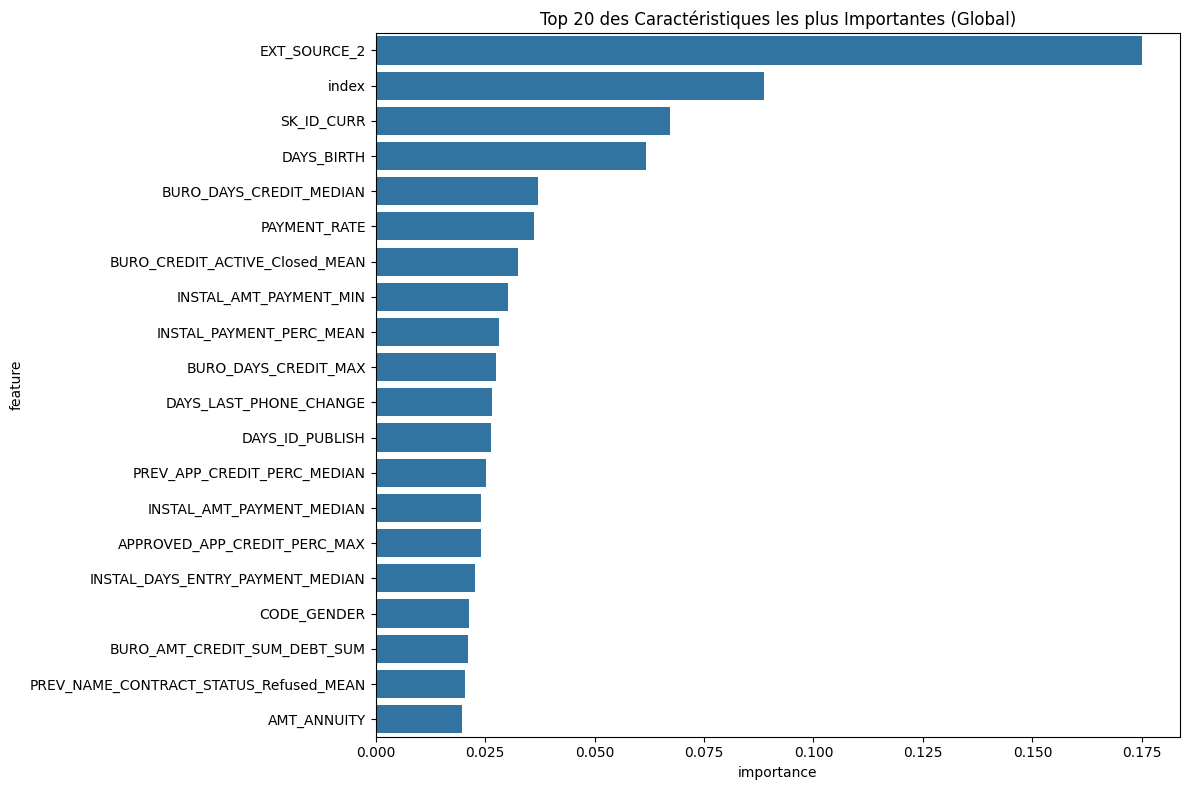

In [15]:
# Importance globale des caractéristiques
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Top 20 des Caractéristiques les plus Importantes (Global)')
plt.tight_layout()
plt.show()

In [16]:
# Pour l'importance locale (SHAP), il faut installer la librairie : pip install shap
import shap
explainer = shap.TreeExplainer(best_rf)

In [ ]:
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test.iloc[0,:], matplotlib=True)

## Evidently

In [ ]:
# Sortir le modèle de la question du drift

# Post Fe =>  selection simple de features

In [ ]:
import evidently.Report

In [14]:
# Préparer les données pour Evidently
# Gardons uniquement les colonnes du modèle final pour une analyse ciblée
train_data_report = X_train_scaled[best_rf.feature_names_in_].copy()
train_data_report['target'] = y_train

test_data_report = pd.DataFrame(X_test_scaled, columns=best_rf.feature_names_in_)
test_data_report['target'] = y_test

# Créer et générer le rapport de dérive des données
data_drift_report = Report(metrics=[
    DataDriftPreset(),
])

data_drift_report.run(reference_data=train_data_report, current_data=test_data_report)

# Sauvegarder le rapport en HTML
data_drift_report.save_html("data_drift_report.html")

print("\nRapport de dérive des données généré : 'data_drift_report.html'.")
# Ouvrez ce fichier dans votre navigateur pour analyser les résultats.
# S'il y a une dérive détectée (p-value < 0.05), cela peut indiquer
# que le modèle pourrait perdre en performance et nécessiter un ré-entraînement.

NameError: name 'best_rf' is not defined

In [ ]:
# datadrift colonnes & datadrift global